100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Displaying 5 samples from the training dataset:


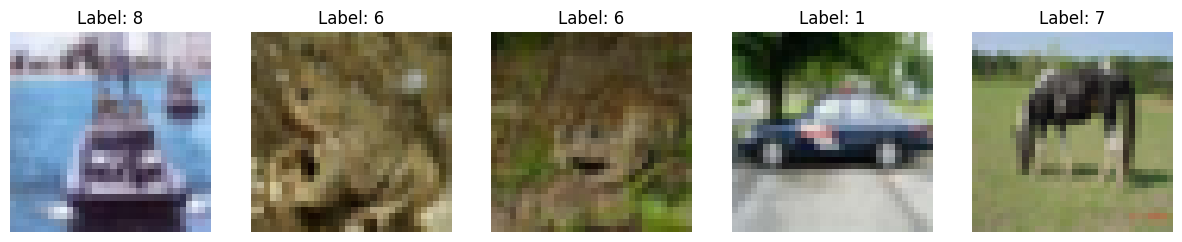

Loading pretrained ResNet-20 model for CIFAR-10...


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 25.3MB/s

Pretrained ResNet-20 model loaded successfully!


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_set) - val_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4)

def show_samples(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        image, label = dataset[i]
        image = (image * 0.5 + 0.5).permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

print("Displaying 5 samples from the training dataset:")
show_samples(train_set)

target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
target_model.eval()


In [ ]:
from collections import Counter

labels = [sample[1] for sample in train_set]
class_counts = Counter(labels)

classes = list(class_counts.keys())
frequencies = list(class_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, frequencies, edgecolor='black', alpha=0.75)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Class Distribution in Dataset', fontsize=14)
plt.xticks(classes, rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
!pip install cleverhans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 9.6 MB/s eta 0:00:00


In [ ]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import numpy as np

# Function to generate adversarial examples and evaluate success rate
def generate_adversarial_examples(model, data_loader, epsilon, device='cuda'):
    model.to(device)
    model.eval()

    total, correct, successful_attacks = 0, 0, 0
    adversarial_images, original_images, differences = [], [], []
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        total += labels.size(0)

        # Generate adversarial examples using FGSM (Fast Gradient Sign Method)
        adv_images = fast_gradient_method(model, images, epsilon, np.inf)

        # Evaluate model on original and adversarial examples
        outputs_original = model(images)
        outputs_adversarial = model(adv_images)

        _, pred_original = outputs_original.max(1)
        _, pred_adversarial = outputs_adversarial.max(1)

        correct += (pred_original == labels).sum().item()
        successful_attacks += (pred_adversarial != labels).sum().item()

        if len(adversarial_images) < 5:
            adversarial_images.append(adv_images[0].cpu().detach())
            original_images.append(images[0].cpu().detach())
            differences.append((adv_images[0] - images[0]).cpu().detach())

    accuracy = correct / total * 100
    attack_success_rate = successful_attacks / total * 100
    print(f"Model accuracy on original test set: {accuracy:.2f}%")
    print(f"Attack success rate: {attack_success_rate:.2f}%")
    visualize_differences(original_images, adversarial_images, differences)

    return adversarial_images, original_images, differences

def visualize_differences(original_images, adversarial_images, differences):
    num_samples = len(original_images)
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        original = original_images[i].permute(1, 2, 0).numpy()
        adversarial = adversarial_images[i].permute(1, 2, 0).numpy()
        difference = differences[i].permute(1, 2, 0).numpy()

        axes[i, 0].imshow(original)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(adversarial)
        axes[i, 1].set_title("Adversarial")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(difference, cmap="viridis")
        axes[i, 2].set_title("Difference")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

epsilon = 0.01
adversarial_images, original_images, differences = generate_adversarial_examples(target_model, test_loader, epsilon)


Model accuracy on original test set: 81.13%
Attack success rate: 63.14%


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/50 | D Loss: 3.6671 | G Loss: 158.9097 | Adv Loss: 0.4444 | Perturb Loss: 15.5317


Model accuracy on original test set: 81.13%
Attack success rate: 50.76%


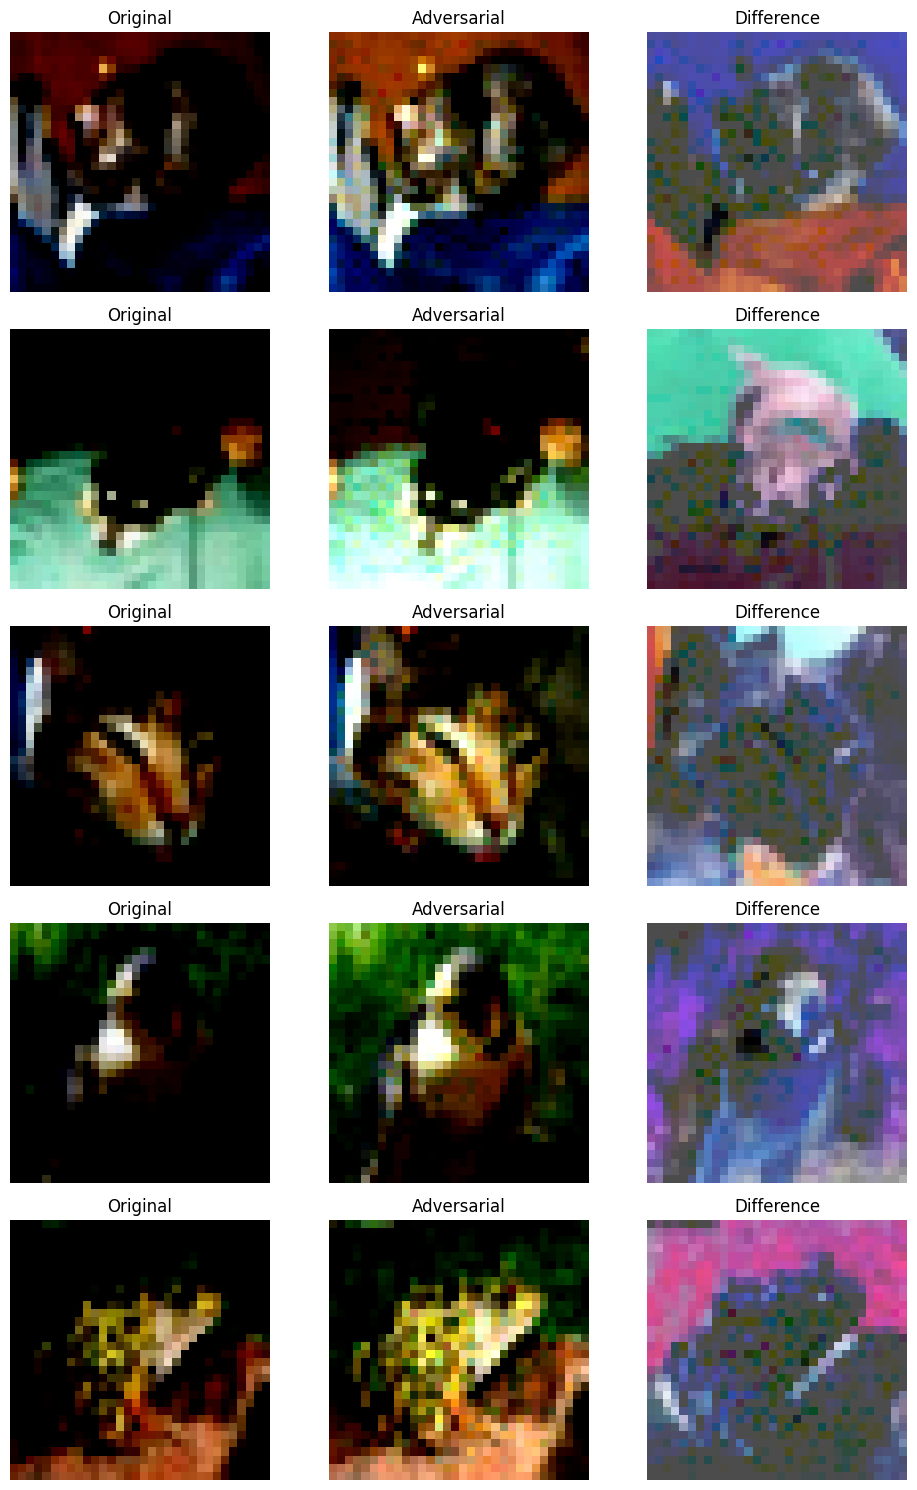

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/50 | D Loss: 1.0133 | G Loss: 175.3166 | Adv Loss: 0.4583 | Perturb Loss: 15.5266


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/50 | D Loss: 0.8221 | G Loss: 178.4854 | Adv Loss: 0.5139 | Perturb Loss: 15.5344


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/50 | D Loss: 0.7573 | G Loss: 176.2990 | Adv Loss: 0.3611 | Perturb Loss: 15.5369


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/50 | D Loss: 1.4173 | G Loss: 176.4857 | Adv Loss: 0.4028 | Perturb Loss: 15.5392


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/50 | D Loss: 0.3400 | G Loss: 180.1479 | Adv Loss: 0.5833 | Perturb Loss: 15.5380


Model accuracy on original test set: 81.13%
Attack success rate: 50.74%


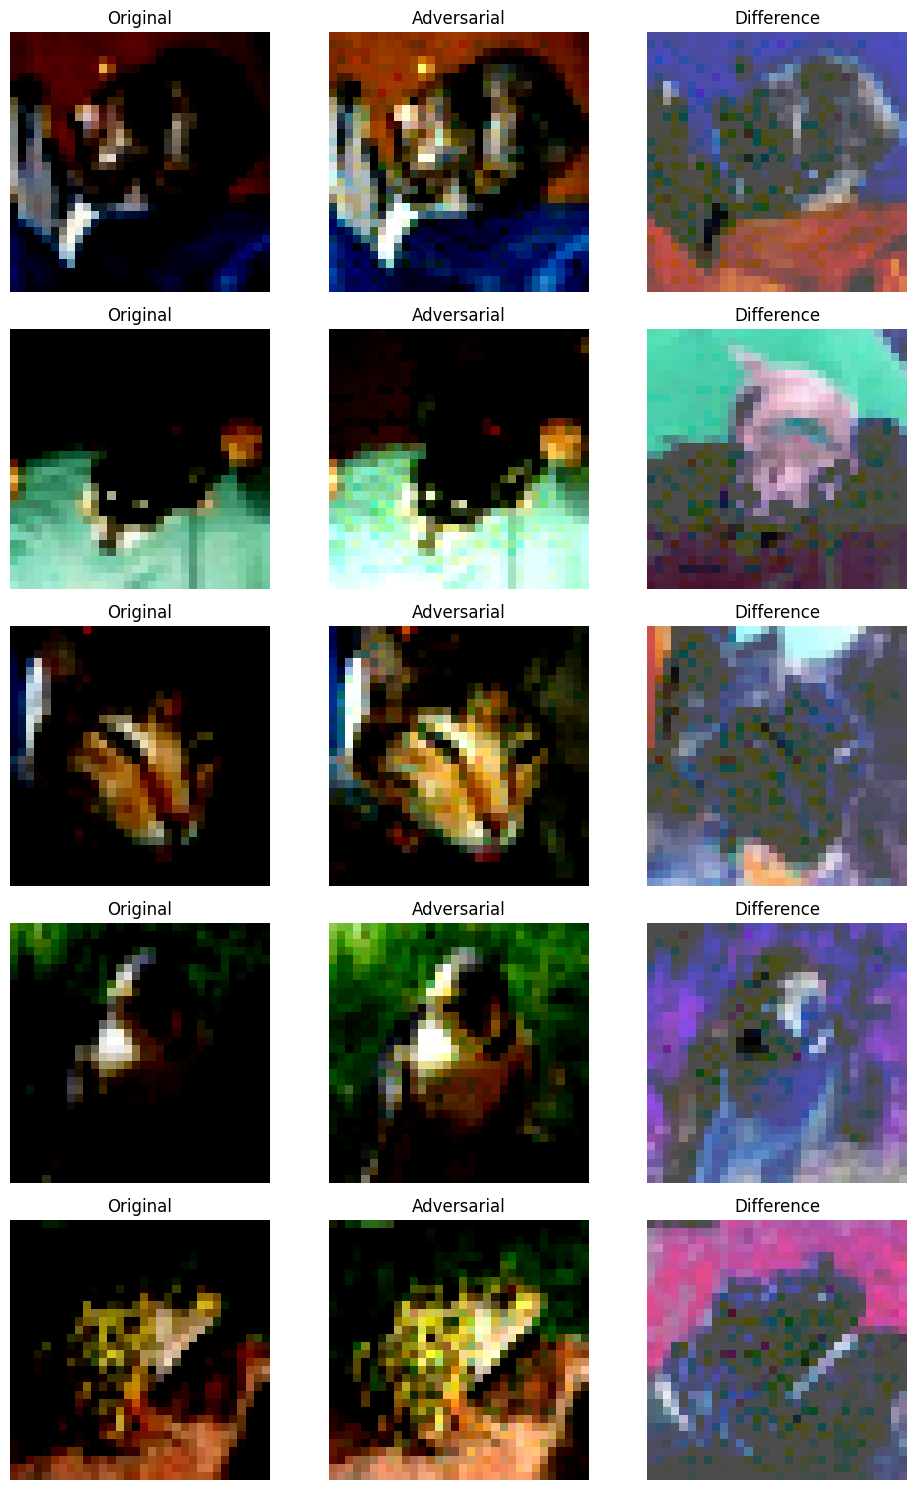

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7/50 | D Loss: 0.2474 | G Loss: 179.3314 | Adv Loss: 0.5417 | Perturb Loss: 15.5322


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8/50 | D Loss: 0.1669 | G Loss: 182.2316 | Adv Loss: 0.4722 | Perturb Loss: 15.5300


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9/50 | D Loss: 0.0407 | G Loss: 182.6340 | Adv Loss: 0.4861 | Perturb Loss: 15.5282


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/50 | D Loss: 1.2346 | G Loss: 181.1343 | Adv Loss: 0.5000 | Perturb Loss: 15.5350


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 11/50 | D Loss: 0.2637 | G Loss: 182.2874 | Adv Loss: 0.5000 | Perturb Loss: 15.5323


Model accuracy on original test set: 81.13%
Attack success rate: 50.73%


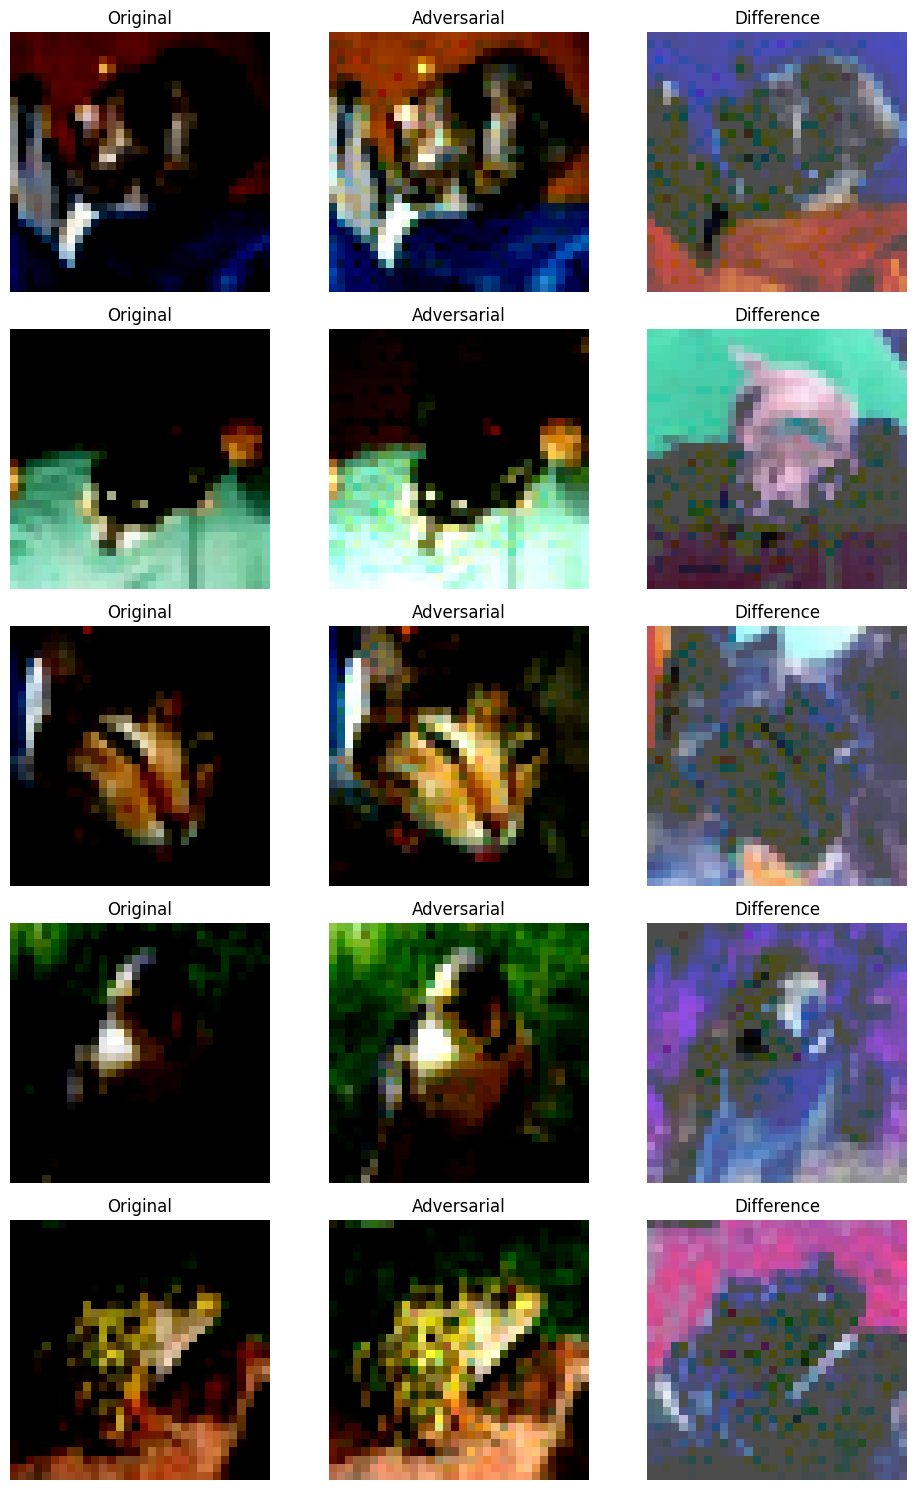

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 12/50 | D Loss: 0.1134 | G Loss: 183.0945 | Adv Loss: 0.4722 | Perturb Loss: 15.5343


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 13/50 | D Loss: 1.6596 | G Loss: 178.2830 | Adv Loss: 0.4583 | Perturb Loss: 15.5311


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 14/50 | D Loss: 0.3639 | G Loss: 182.2487 | Adv Loss: 0.4444 | Perturb Loss: 15.5335


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15/50 | D Loss: 0.0676 | G Loss: 182.6543 | Adv Loss: 0.4167 | Perturb Loss: 15.5304


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 16/50 | D Loss: 1.0024 | G Loss: 181.3120 | Adv Loss: 0.4444 | Perturb Loss: 15.5328


Model accuracy on original test set: 81.13%
Attack success rate: 50.80%


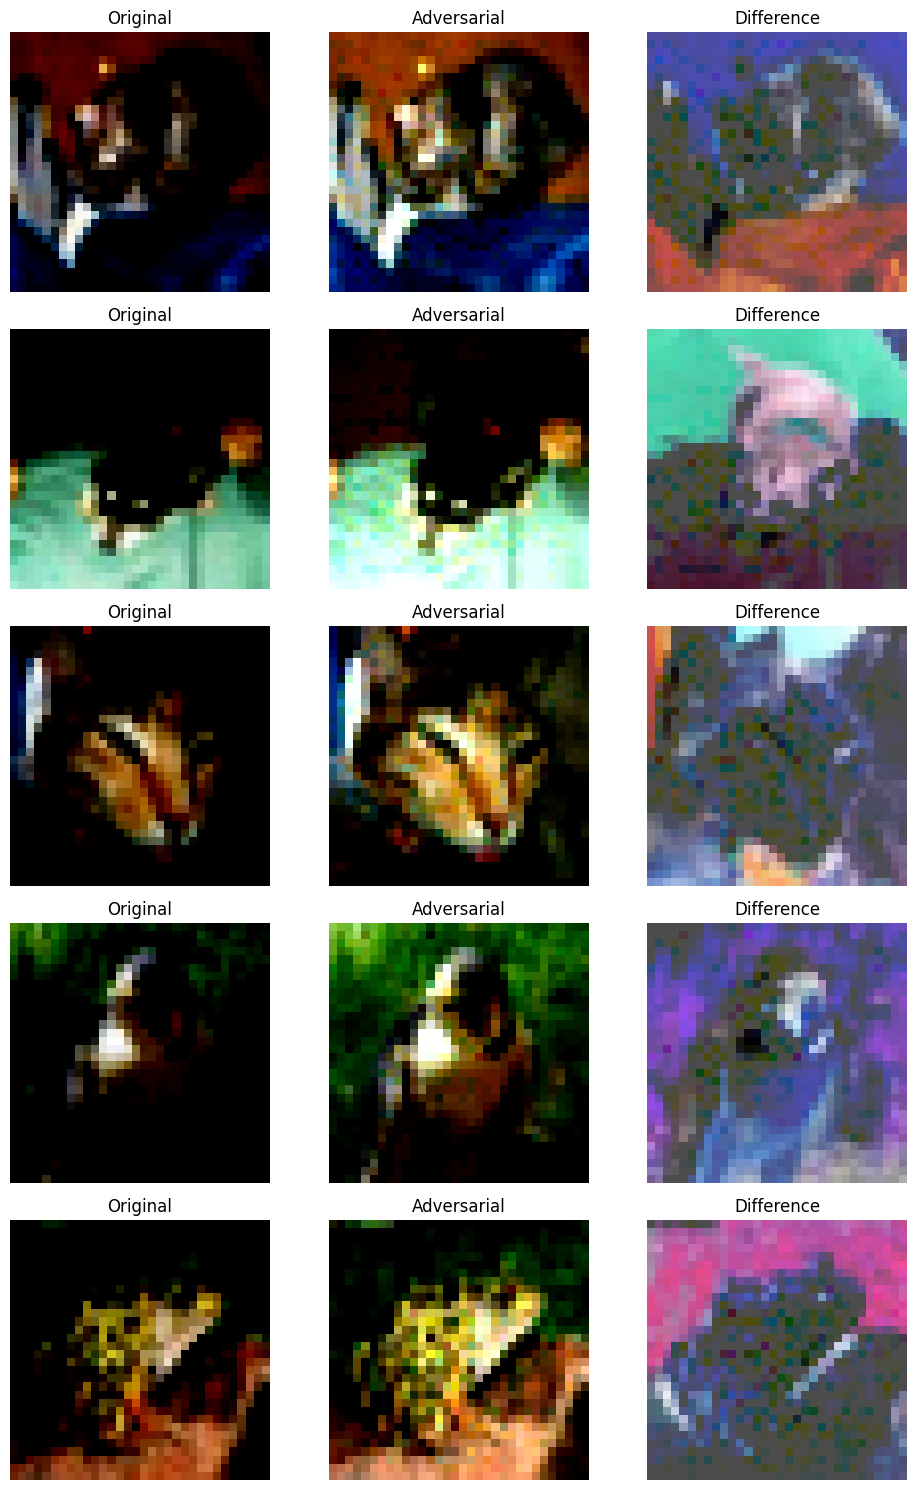

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 17/50 | D Loss: 0.0376 | G Loss: 183.4081 | Adv Loss: 0.4028 | Perturb Loss: 15.5324


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 18/50 | D Loss: 1.2265 | G Loss: 178.9158 | Adv Loss: 0.4861 | Perturb Loss: 15.5363


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 19/50 | D Loss: 0.0269 | G Loss: 183.6748 | Adv Loss: 0.4861 | Perturb Loss: 15.5327


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20/50 | D Loss: 0.5931 | G Loss: 183.0856 | Adv Loss: 0.5417 | Perturb Loss: 15.5324


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 21/50 | D Loss: 0.8455 | G Loss: 180.8775 | Adv Loss: 0.6667 | Perturb Loss: 15.5375


Model accuracy on original test set: 81.13%
Attack success rate: 50.79%


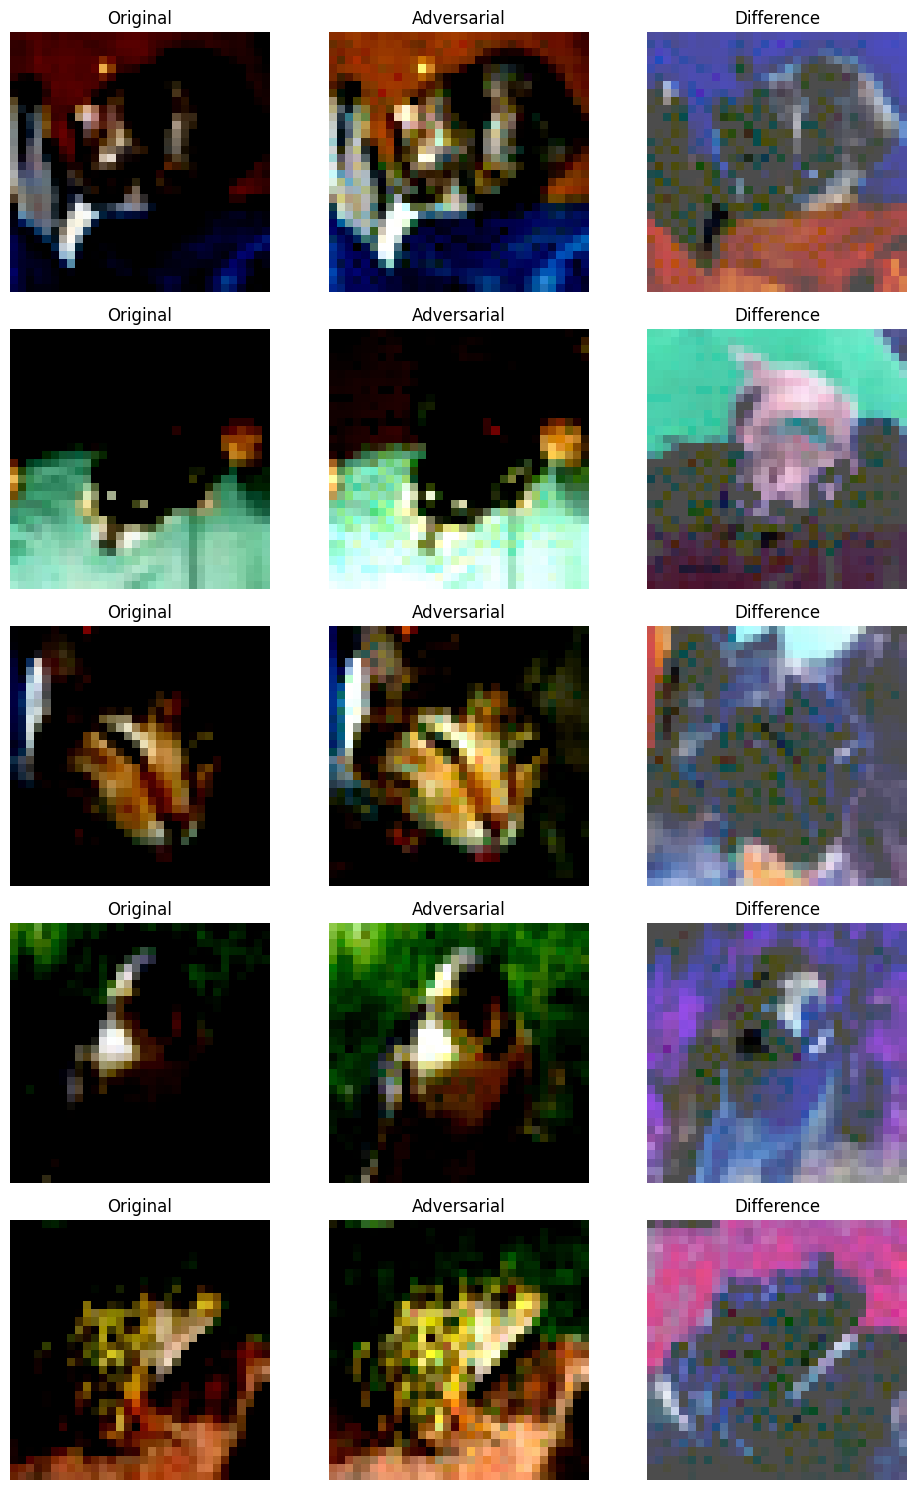

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 22/50 | D Loss: 0.3081 | G Loss: 182.6957 | Adv Loss: 0.5139 | Perturb Loss: 15.5295


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 23/50 | D Loss: 0.0337 | G Loss: 183.7397 | Adv Loss: 0.5139 | Perturb Loss: 15.5358


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 24/50 | D Loss: 0.0360 | G Loss: 183.2392 | Adv Loss: 0.5000 | Perturb Loss: 15.5371


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25/50 | D Loss: 0.5394 | G Loss: 183.9384 | Adv Loss: 0.3889 | Perturb Loss: 15.5335


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 26/50 | D Loss: 0.0521 | G Loss: 183.6539 | Adv Loss: 0.5417 | Perturb Loss: 15.5354


Model accuracy on original test set: 81.13%
Attack success rate: 50.75%


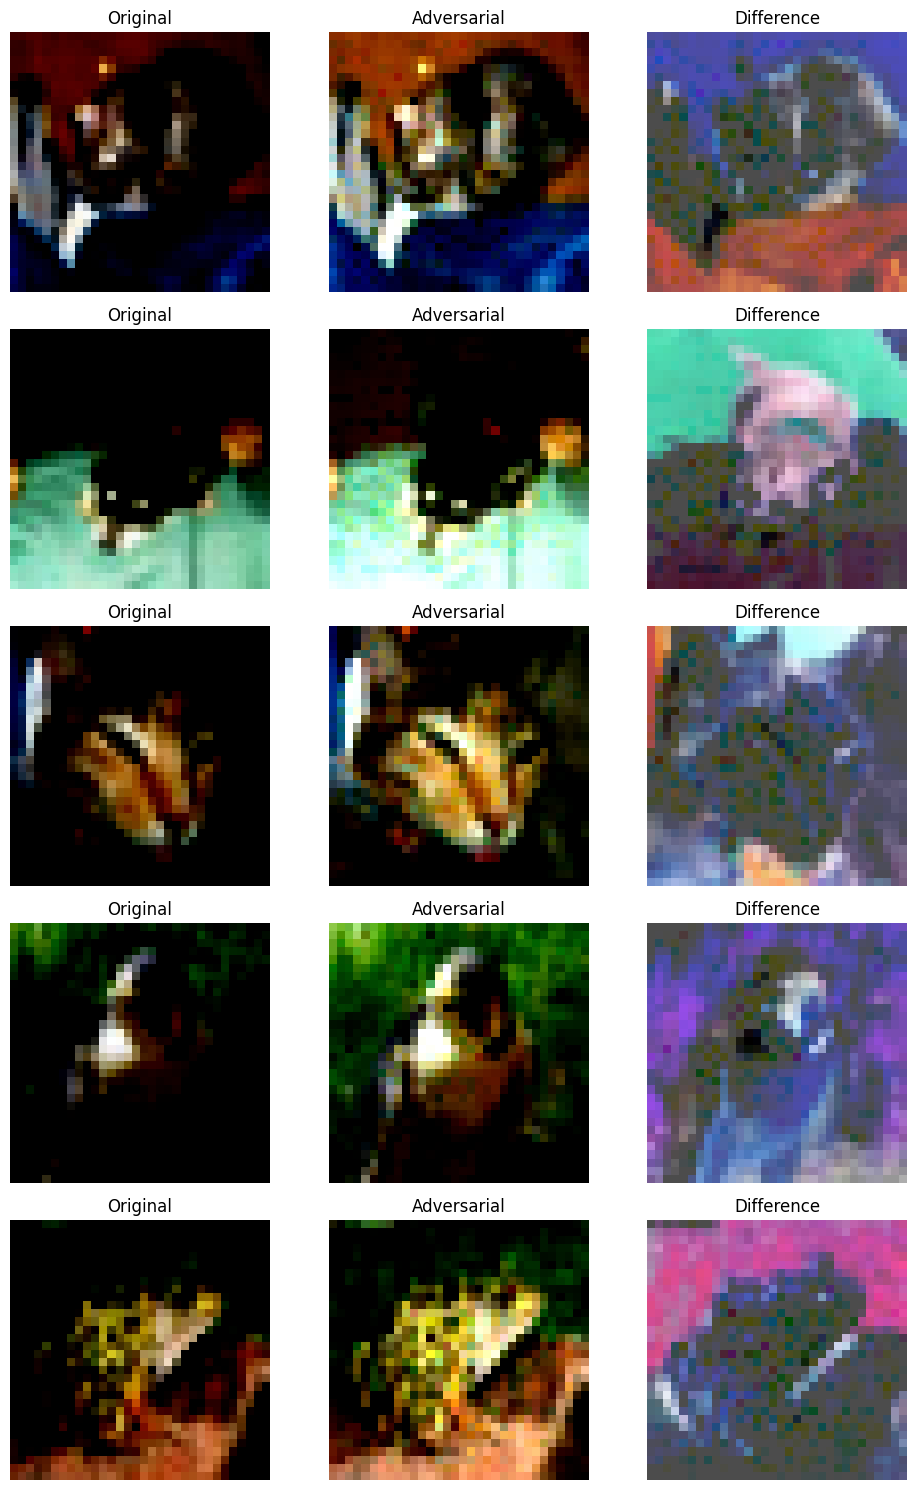

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 27/50 | D Loss: 0.0518 | G Loss: 183.8971 | Adv Loss: 0.5000 | Perturb Loss: 15.5335


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 28/50 | D Loss: 0.0402 | G Loss: 183.2306 | Adv Loss: 0.5139 | Perturb Loss: 15.5353


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 29/50 | D Loss: 0.0055 | G Loss: 183.7645 | Adv Loss: 0.5000 | Perturb Loss: 15.5382


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 30/50 | D Loss: 0.0542 | G Loss: 183.5471 | Adv Loss: 0.4583 | Perturb Loss: 15.5351


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 31/50 | D Loss: 0.1929 | G Loss: 182.9895 | Adv Loss: 0.4861 | Perturb Loss: 15.5400
Model accuracy on original test set: 81.13%
Attack success rate: 50.76%


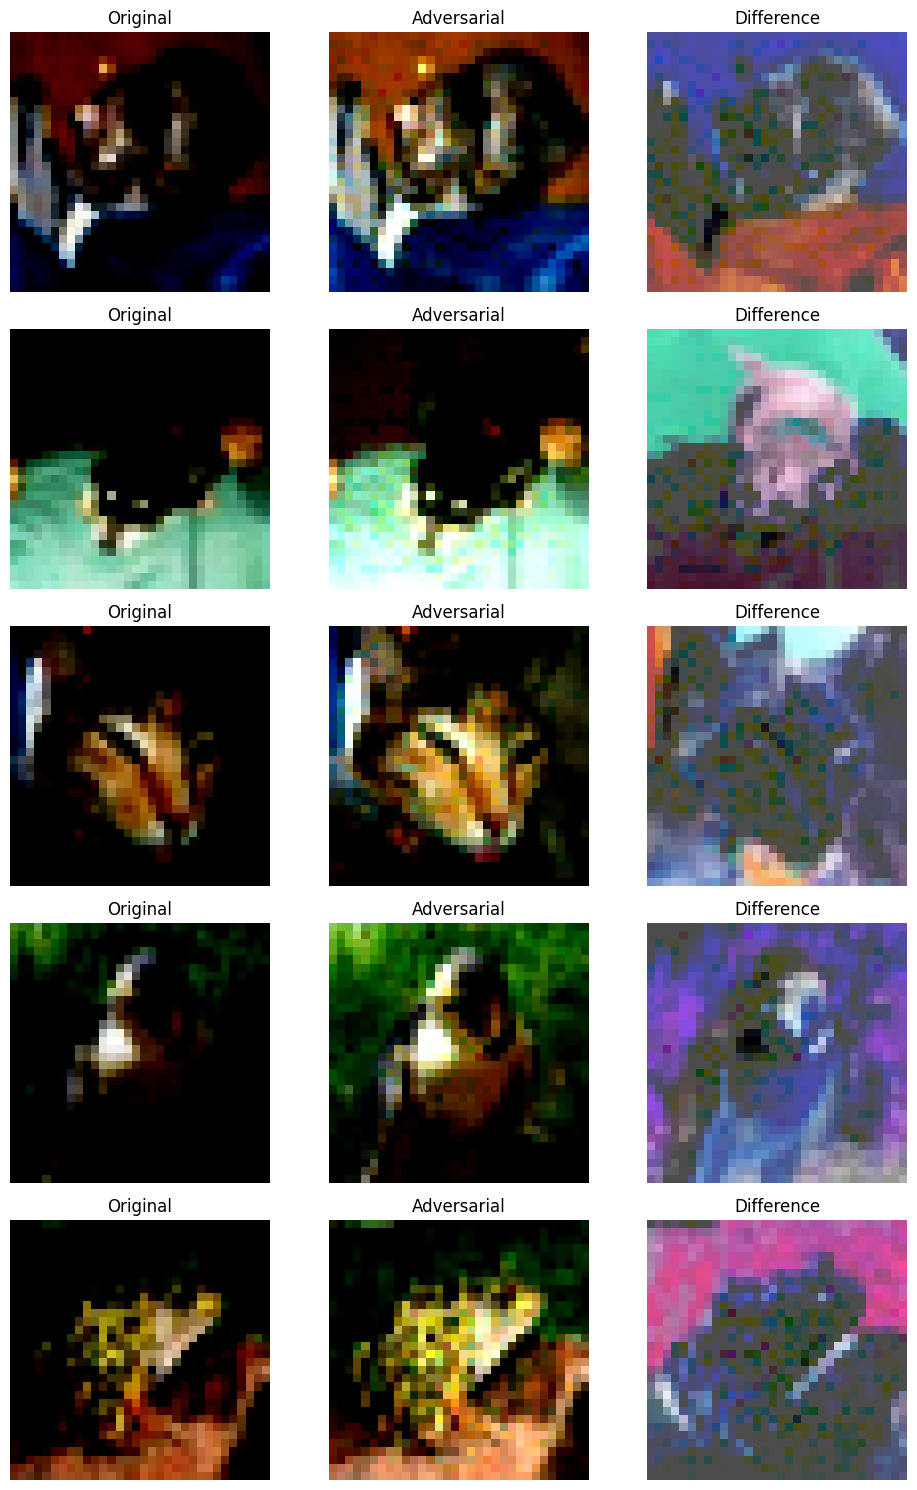

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 32/50 | D Loss: 0.3348 | G Loss: 182.8281 | Adv Loss: 0.4028 | Perturb Loss: 15.5348


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 33/50 | D Loss: 1.0779 | G Loss: 183.1654 | Adv Loss: 0.5278 | Perturb Loss: 15.5323


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 34/50 | D Loss: 0.0024 | G Loss: 183.5980 | Adv Loss: 0.5417 | Perturb Loss: 15.5397


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 35/50 | D Loss: 0.2015 | G Loss: 183.3087 | Adv Loss: 0.4583 | Perturb Loss: 15.5404


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 36/50 | D Loss: 0.0231 | G Loss: 183.4903 | Adv Loss: 0.5139 | Perturb Loss: 15.5337


Model accuracy on original test set: 81.13%
Attack success rate: 50.80%


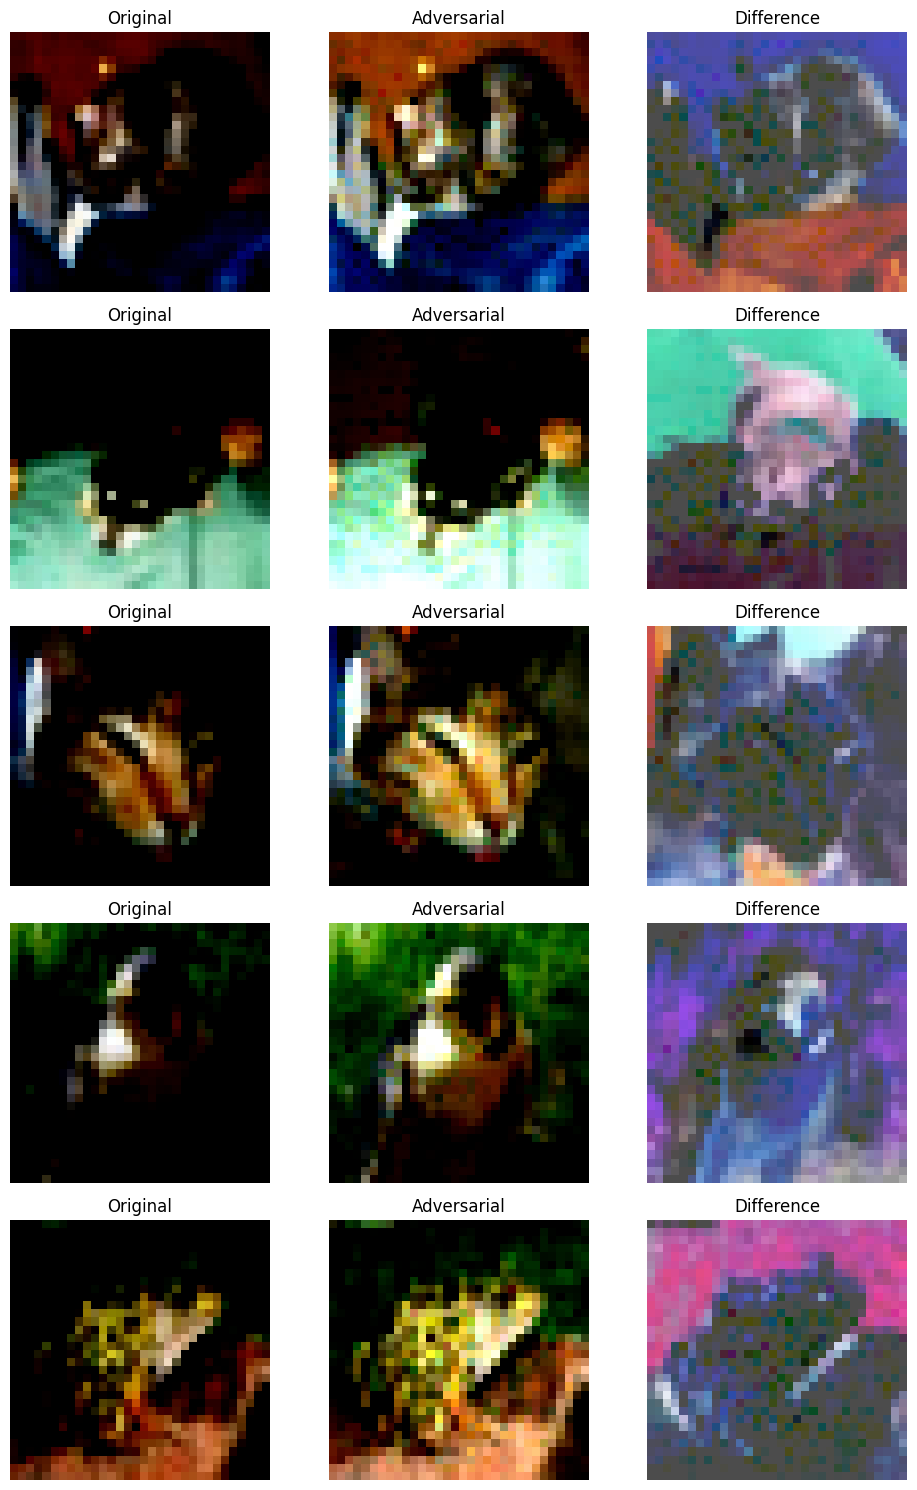

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 37/50 | D Loss: 0.0498 | G Loss: 183.6357 | Adv Loss: 0.5972 | Perturb Loss: 15.5301


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 38/50 | D Loss: 0.1534 | G Loss: 182.6241 | Adv Loss: 0.4861 | Perturb Loss: 15.5448


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 39/50 | D Loss: 0.0309 | G Loss: 183.7969 | Adv Loss: 0.5139 | Perturb Loss: 15.5399


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 40/50 | D Loss: 1.2892 | G Loss: 183.4952 | Adv Loss: 0.5278 | Perturb Loss: 15.5396


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 41/50 | D Loss: 0.0169 | G Loss: 183.8426 | Adv Loss: 0.4861 | Perturb Loss: 15.5367


Model accuracy on original test set: 81.13%
Attack success rate: 50.76%


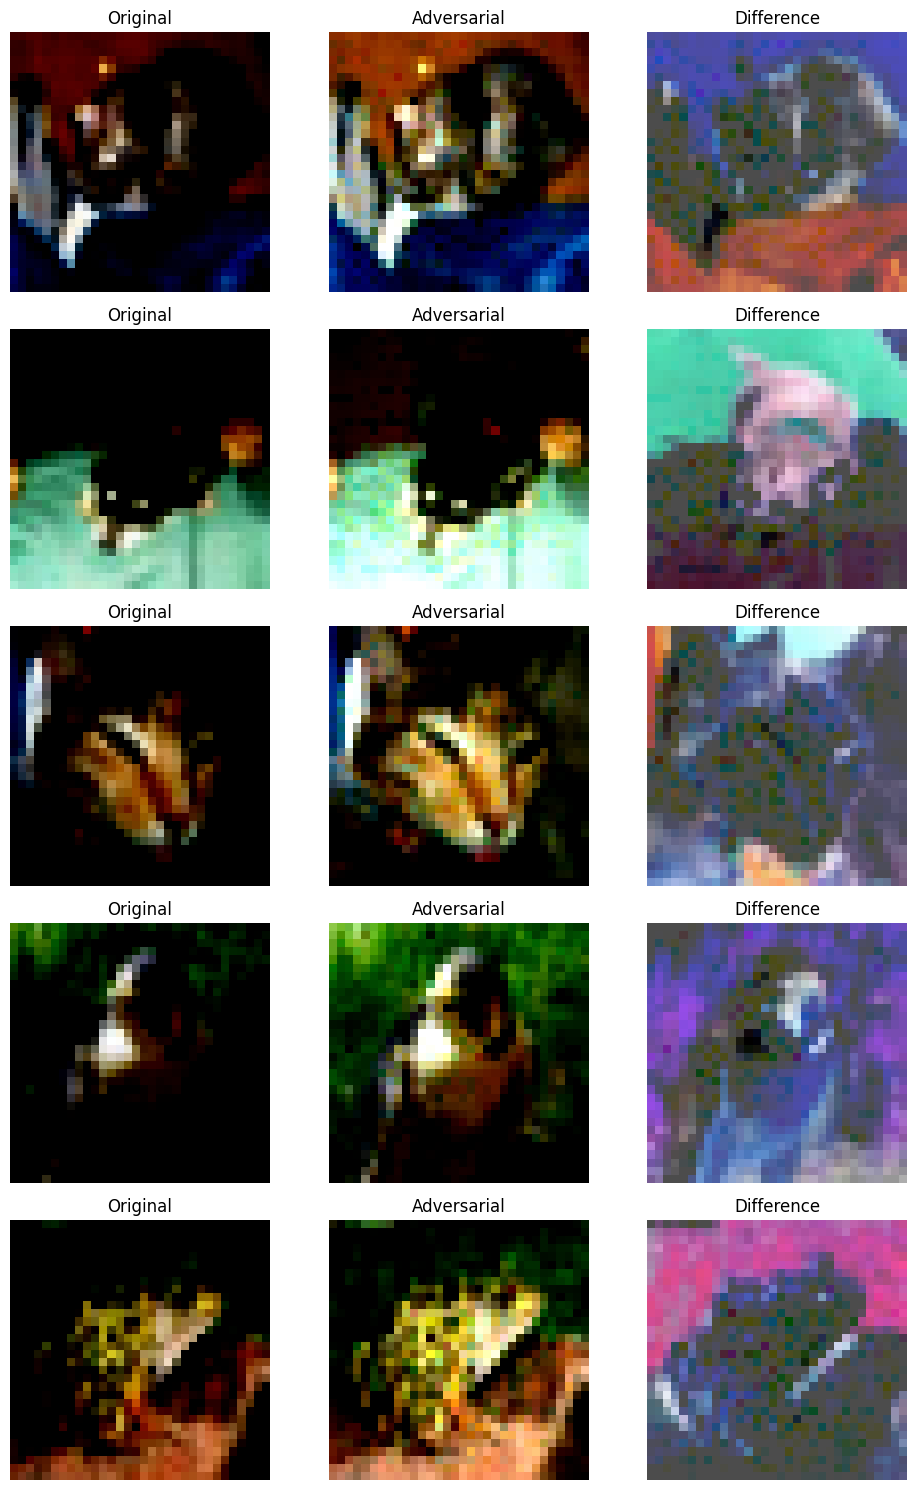

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 42/50 | D Loss: 0.3573 | G Loss: 183.4313 | Adv Loss: 0.5417 | Perturb Loss: 15.5333


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 43/50 | D Loss: 0.0107 | G Loss: 183.9178 | Adv Loss: 0.5000 | Perturb Loss: 15.5320


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 44/50 | D Loss: 0.3961 | G Loss: 182.6307 | Adv Loss: 0.5833 | Perturb Loss: 15.5346


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 45/50 | D Loss: 0.0168 | G Loss: 183.7673 | Adv Loss: 0.4722 | Perturb Loss: 15.5373


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 46/50 | D Loss: 0.0697 | G Loss: 183.1228 | Adv Loss: 0.4722 | Perturb Loss: 15.5376


Model accuracy on original test set: 81.13%
Attack success rate: 50.78%


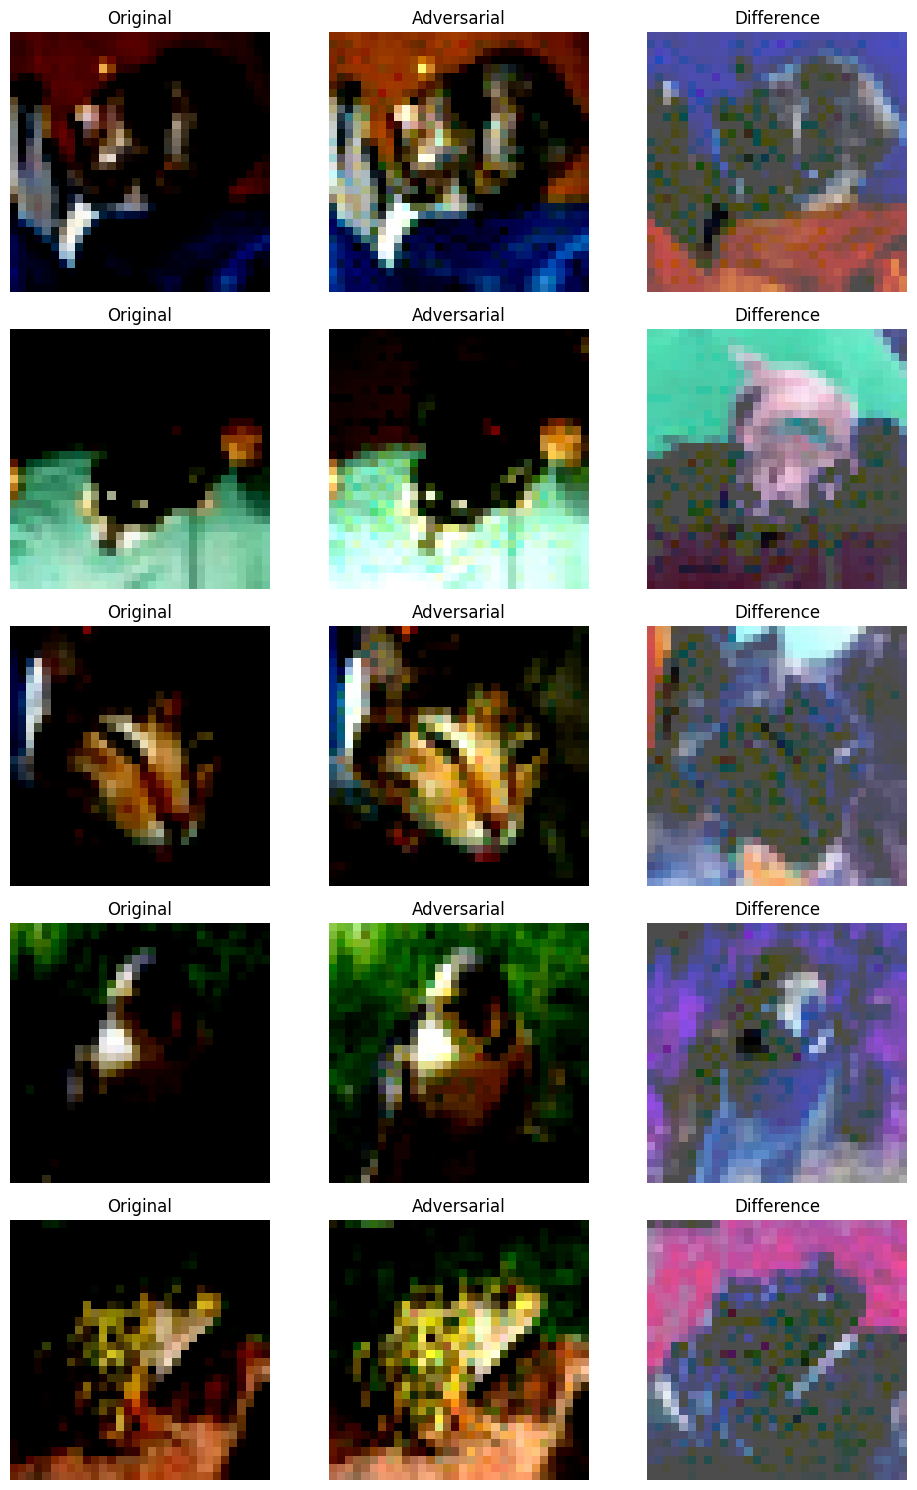

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 47/50 | D Loss: 0.0009 | G Loss: 183.8602 | Adv Loss: 0.4444 | Perturb Loss: 15.5334


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 48/50 | D Loss: 0.0028 | G Loss: 183.8265 | Adv Loss: 0.5000 | Perturb Loss: 15.5324


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 49/50 | D Loss: 0.0159 | G Loss: 183.9807 | Adv Loss: 0.5139 | Perturb Loss: 15.5373


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 50/50 | D Loss: 0.0107 | G Loss: 183.9115 | Adv Loss: 0.5278 | Perturb Loss: 15.5392


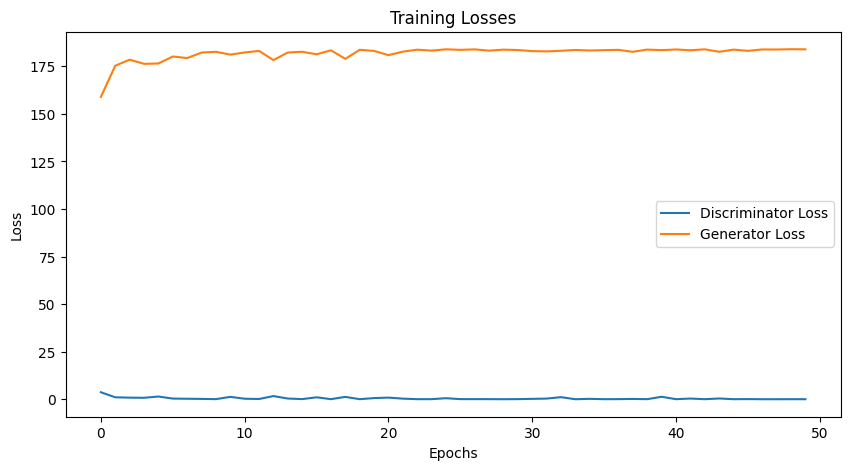

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import itertools
from tqdm.notebook import tqdm

# Convolution -> Instance Norm -> ReLU
class ConvInstNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ConvInstNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2)
        self.inst_norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.inst_norm(x)
        return self.relu(x)

# Transposed Convolution -> Instance Norm -> ReLU
class TransConvInstNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2):
        super(TransConvInstNormRelu, self).__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2, output_padding=stride-1)
        self.inst_norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.trans_conv(x)
        x = self.inst_norm(x)
        return self.relu(x)

# Residual Block with Batch Normalization
class ResBlock(nn.Module):
    def __init__(self, channels=3, kernel_size=3):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # Save input for skip connection
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return identity + out  # Skip connection

class Generator(nn.Module):
    def __init__(self, input_channels=3):  # Change from 1 to 3 for RGB images
        super(Generator, self).__init__()

        # Encoding Path (Conv -> Downsample)
        self.c1 = ConvInstNormRelu(input_channels, 32, kernel_size=3, stride=1)
        self.d1 = ConvInstNormRelu(32, 64, kernel_size=3, stride=2)
        self.d2 = ConvInstNormRelu(64, 128, kernel_size=3, stride=2)

        # Residual Blocks
        self.rb1 = ResBlock(128)
        self.rb2 = ResBlock(128)
        self.rb3 = ResBlock(128)
        self.rb4 = ResBlock(128)

        # Decoding Path (Upsampling)
        self.u1 = TransConvInstNormRelu(128, 64, kernel_size=3, stride=2)
        self.u2 = TransConvInstNormRelu(64, 32, kernel_size=3, stride=2)

        # Output Layer
        self.out = nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Sigmoid()

    def forward(self, x):
        # Encoding path
        x = self.c1(x)
        x = self.d1(x)
        x = self.d2(x)

        # Residual blocks
        x = self.rb1(x)
        x = self.rb2(x)
        x = self.rb3(x)
        x = self.rb4(x)

        # Decoding path
        x = self.u1(x)
        x = self.u2(x)

        # Output layer
        x = self.out(x)
        return self.tanh(x)  # Tanh activation to keep perturbation values in range [-1,1]


# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=4, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0)

        self.inst_norm1 = nn.InstanceNorm2d(16)
        self.inst_norm2 = nn.InstanceNorm2d(16)

        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.fc = nn.Linear(128, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x)) 
        x = self.leaky_relu(self.inst_norm1(self.conv2(x)))
        x = self.leaky_relu(self.inst_norm2(self.conv3(x))) 

        x = torch.flatten(x, start_dim=1)

        logits = self.fc(x)
        probs = self.sigmoid(logits)

        return probs

def compute_attack_success(generator, target_model, data_loader, threshold, device):
    target_model.to(device)
    target_model.eval()
    generator.eval()

    total, correct, successful_attacks = 0, 0, 0
    adversarial_images, original_images, differences = [], [], []

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        total += labels.size(0)

        # Generate adversarial perturbations
        perturbations = generator(images)
        perturbations = torch.clamp(perturbations, -threshold, threshold)
        adv_images = torch.clamp(images + perturbations, 0, 1)

        # Evaluate model on original and adversarial examples
        outputs_original = target_model(images)
        outputs_adversarial = target_model(adv_images)

        _, pred_original = outputs_original.max(1)
        _, pred_adversarial = outputs_adversarial.max(1)

        # Count correct predictions
        correct += (pred_original == labels).sum().item()
        successful_attacks += (pred_adversarial != labels).sum().item()

        # Save samples for visualization
        if len(adversarial_images) < 5:
            adversarial_images.append(adv_images[0].cpu().detach())
            original_images.append(images[0].cpu().detach())
            differences.append((adv_images[0] - images[0]).cpu().detach())

    accuracy = correct / total * 100
    attack_success_rate = successful_attacks / total * 100
    print(f"Model accuracy on original test set: {accuracy:.2f}%")
    print(f"Attack success rate: {attack_success_rate:.2f}%")

    visualize_differences(original_images, adversarial_images, differences)

    return adversarial_images, original_images, differences


# Training Setup
def train_advgan(generator, discriminator, target_model, train_loader, val_loader, epochs=50, alpha=10.0, beta=1.0, threshold=0.3, g_train_steps=4, target=-1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    target_model = target_model.to(device)

    g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)

    mse_loss = nn.MSELoss(reduction='sum')
    attack_success_rates = []

    d_losses, g_losses, adv_losses, perturb_losses = [], [], [], []

    is_targeted = False
    if target in range(0, 10):
        is_targeted = True

    for epoch in range(epochs):
        generator.train()
        discriminator.train()

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            if is_targeted:
                labels = torch.ones_like(labels) * target

            # Generate adversarial perturbations
            perturbations = generator(images).detach().clone()
            perturbations = torch.clamp(perturbations, -threshold, threshold)
            perturbed_images = torch.clamp(images + perturbations, 0, 1)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_preds = discriminator(images)
            fake_preds = discriminator(perturbed_images.detach())

            real_labels = torch.ones_like(real_preds)
            fake_labels = torch.zeros_like(fake_preds)

            d_loss_real = mse_loss(real_preds, real_labels)
            d_loss_fake = mse_loss(fake_preds, fake_labels)
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train Generator multiple times per discriminator update
            for _ in range(g_train_steps):
                g_optimizer.zero_grad()
                fake_preds = discriminator(perturbed_images)
                g_loss_fake = mse_loss(fake_preds, real_labels)

                with torch.no_grad():
                    target_preds = target_model(perturbed_images)

                l_adv = torch.mean((target_preds.argmax(1) != labels).float())
                l_perturb = torch.mean(torch.norm(perturbations.view(perturbations.size(0), -1), dim=1))

                g_loss = (l_adv + alpha * g_loss_fake + beta * l_perturb) / g_train_steps
                g_loss.backward(retain_graph=True)
                g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        adv_losses.append(l_adv.item())
        perturb_losses.append(l_perturb.item())

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | Adv Loss: {l_adv.item():.4f} | Perturb Loss: {l_perturb.item():.4f}")

        if epoch % 5 == 0:
            compute_attack_success(generator, target_model, test_loader, threshold, device)


    # Plot Loss Graphs
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.show()

    return generator, discriminator

# Initialize models and train
generator = Generator()
discriminator = Discriminator()
trained_generator, trained_discriminator = train_advgan(generator, discriminator, target_model, train_loader, val_loader)



Model accuracy on original test set: 81.13%
Attack success rate: 50.78%


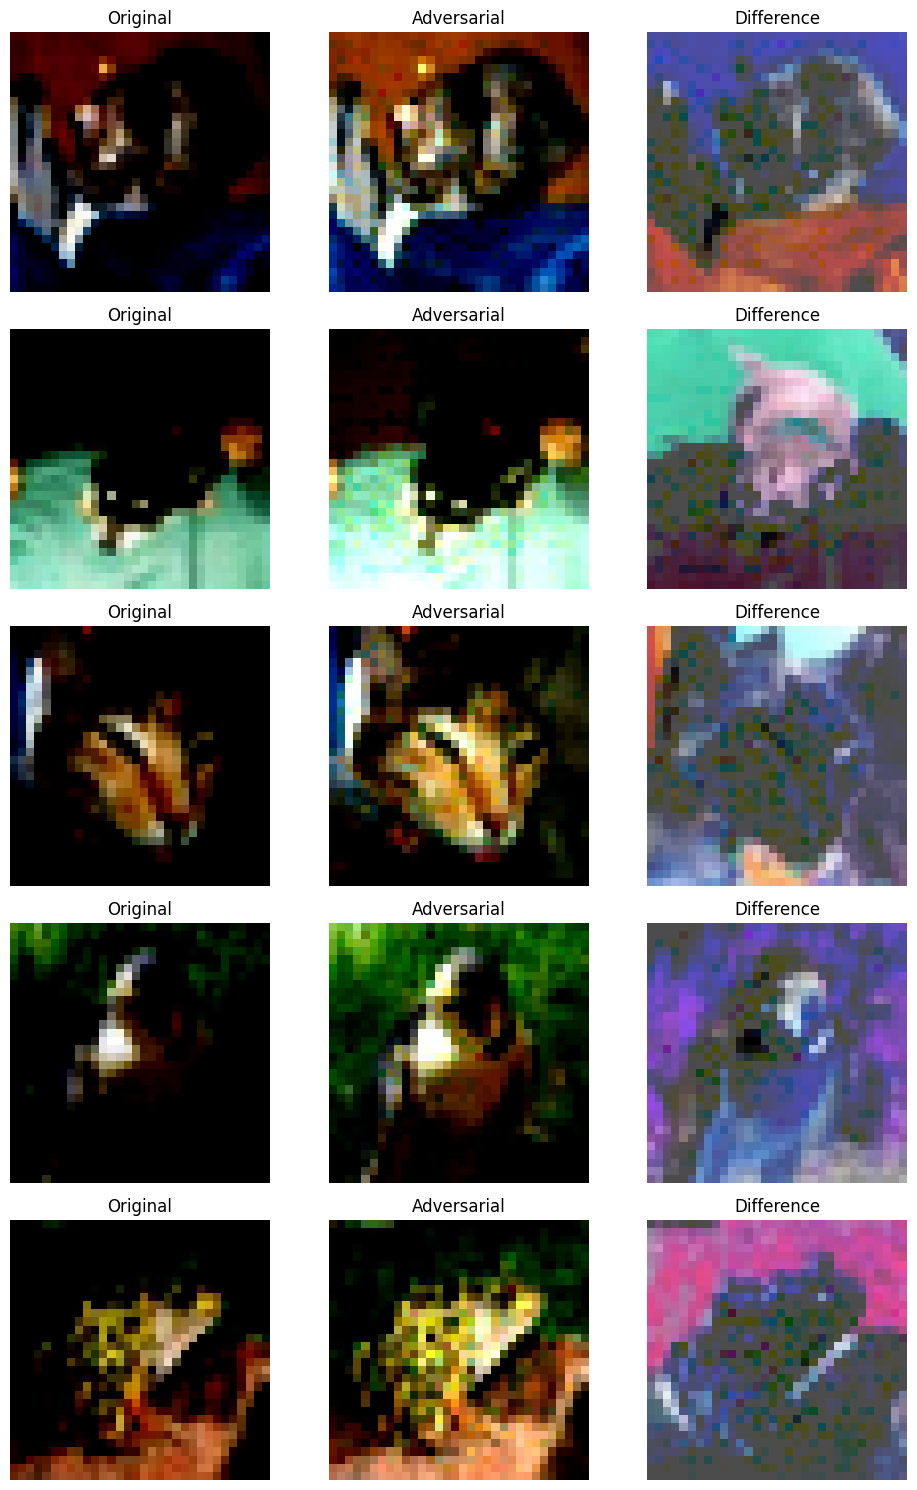

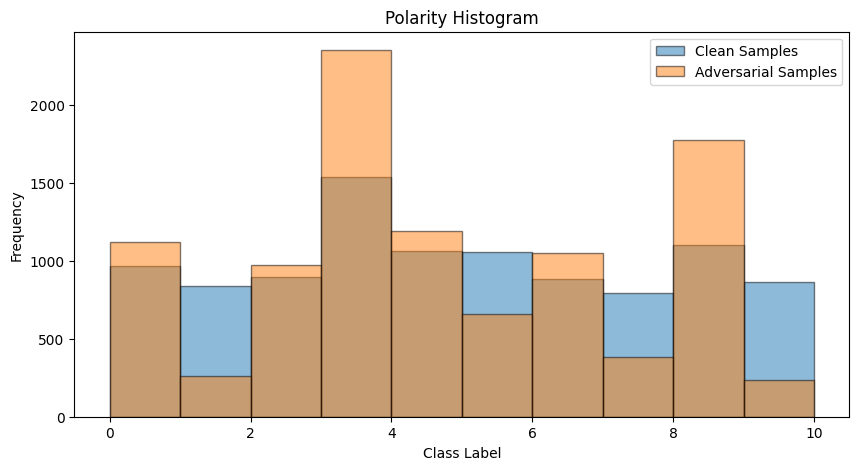

In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


def compute_attack_success(generator, target_model, data_loader, threshold, device):
    target_model.to(device)
    target_model.eval()
    generator.eval()

    total, correct, successful_attacks = 0, 0, 0
    adversarial_images, original_images, differences = [], [], []

    # Iterate over the test data
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        total += labels.size(0)

        # Generate adversarial perturbations
        perturbations = generator(images)
        perturbations = torch.clamp(perturbations, -threshold, threshold)
        adv_images = torch.clamp(images + perturbations, 0, 1)

        # Evaluate model on original and adversarial examples
        outputs_original = target_model(images)
        outputs_adversarial = target_model(adv_images)

        _, pred_original = outputs_original.max(1)
        _, pred_adversarial = outputs_adversarial.max(1)

        # Count correct predictions
        correct += (pred_original == labels).sum().item()
        successful_attacks += (pred_adversarial != labels).sum().item()

        # Save samples for visualization
        if len(adversarial_images) < 5:
            adversarial_images.append(adv_images[0].cpu().detach())
            original_images.append(images[0].cpu().detach())
            differences.append((adv_images[0] - images[0]).cpu().detach())

    accuracy = correct / total * 100
    attack_success_rate = successful_attacks / total * 100
    print(f"Model accuracy on original test set: {accuracy:.2f}%")
    print(f"Attack success rate: {attack_success_rate:.2f}%")

    # Visualize differences
    visualize_differences(original_images, adversarial_images, differences)

    return adversarial_images, original_images, differences

# Function to plot polarity histogram
def plot_polarity_histogram(generator, target_model, data_loader, device):
    generator.eval()
    target_model.eval()

    clean_predictions = []
    adv_predictions = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)

            # Clean predictions
            clean_preds = target_model(images).argmax(dim=1).cpu().numpy()
            clean_predictions.extend(clean_preds)

            # Generate adversarial samples
            perturbations = generator(images)
            perturbations = torch.clamp(perturbations, -0.3, 0.3)
            adv_images = torch.clamp(images + perturbations, 0, 1)

            # Adversarial predictions
            adv_preds = target_model(adv_images).argmax(dim=1).cpu().numpy()
            adv_predictions.extend(adv_preds)

    plt.figure(figsize=(10, 5))
    plt.hist(clean_predictions, bins=range(len(set(clean_predictions))+1), alpha=0.5, label="Clean Samples", edgecolor='black')
    plt.hist(adv_predictions, bins=range(len(set(adv_predictions))+1), alpha=0.5, label="Adversarial Samples", edgecolor='black')
    plt.xlabel("Class Label")
    plt.ylabel("Frequency")
    plt.title("Polarity Histogram")
    plt.legend()
    plt.show()


compute_attack_success(trained_generator, target_model, test_loader, threshold=0.3, device='cuda')

# Plot polarity histogram
plot_polarity_histogram(trained_generator, target_model, test_loader, device)


Model accuracy on original test set: 81.13%
Overall attack success rate: 50.78%
Class 0:
  Accuracy: 84.10%
  Attack Success Rate: 44.40%
Class 1:
  Accuracy: 82.00%
  Attack Success Rate: 74.30%
Class 2:
  Accuracy: 74.20%
  Attack Success Rate: 48.60%
Class 3:
  Accuracy: 82.50%
  Attack Success Rate: 32.90%
Class 4:
  Accuracy: 83.50%
  Attack Success Rate: 40.80%
Class 5:
  Accuracy: 73.00%
  Attack Success Rate: 68.70%
Class 6:
  Accuracy: 80.40%
  Attack Success Rate: 35.30%
Class 7:
  Accuracy: 76.70%
  Attack Success Rate: 63.90%
Class 8:
  Accuracy: 92.40%
  Attack Success Rate: 20.70%
Class 9:
  Accuracy: 82.50%
  Attack Success Rate: 78.20%


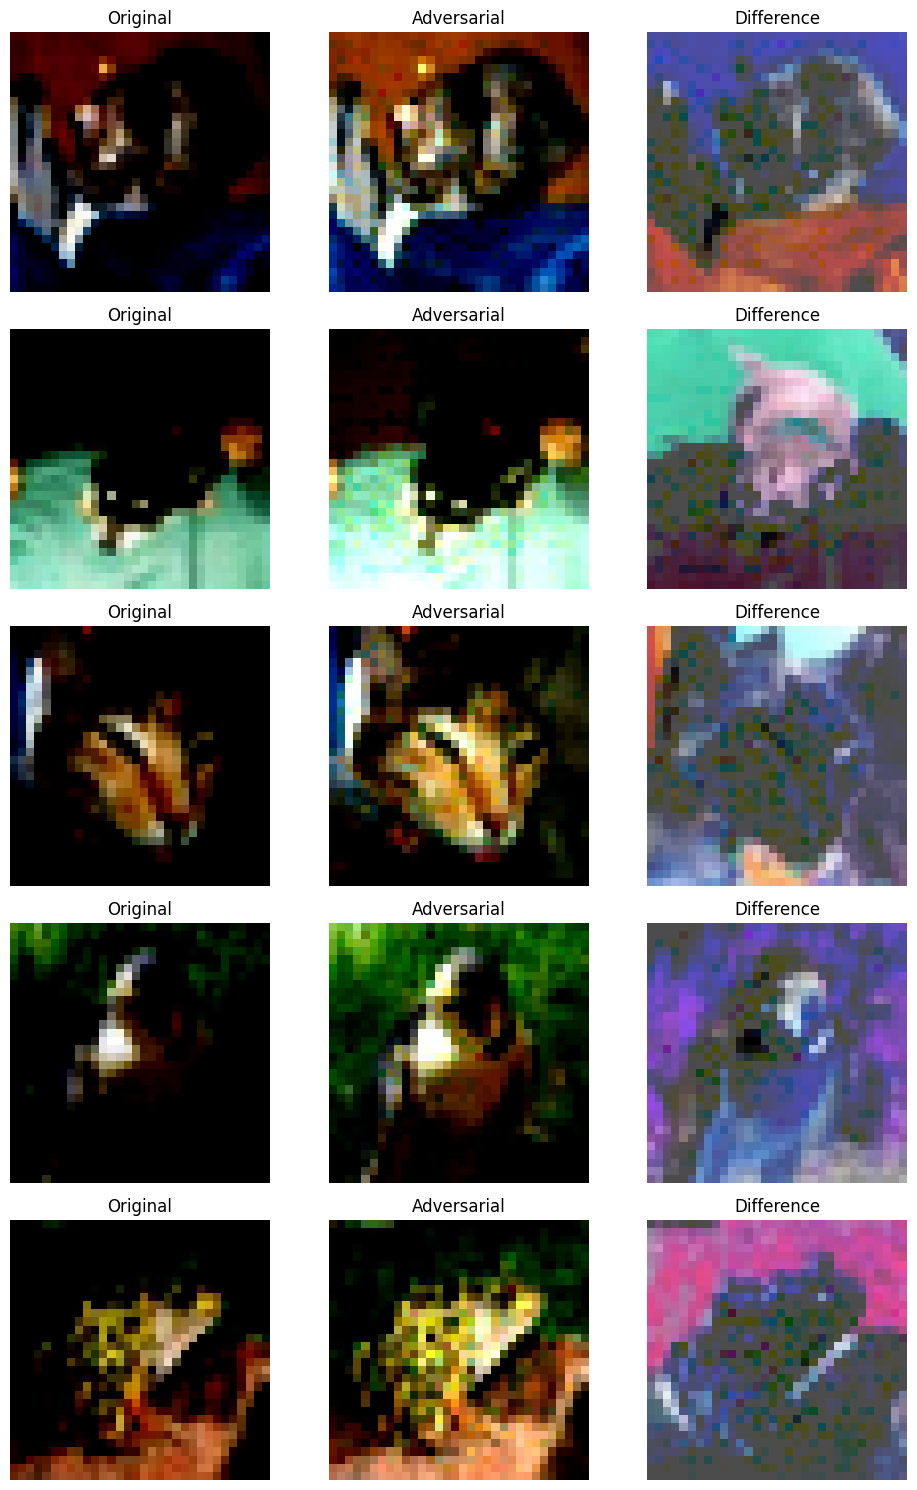

In [42]:
def compute_attack_success_per_class(generator, target_model, data_loader, threshold, device, num_classes):
    target_model.to(device)
    target_model.eval()
    generator.eval()

    # Initialize counters
    total_samples_per_class = [0] * num_classes
    correct_predictions_per_class = [0] * num_classes
    successful_attacks_per_class = [0] * num_classes

    adversarial_images, original_images, differences = [], [], []

    # Iterate over the test data
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        # Generate adversarial perturbations
        perturbations = generator(images)
        perturbations = torch.clamp(perturbations, -threshold, threshold)
        adv_images = torch.clamp(images + perturbations, 0, 1)

        # Evaluate model on original and adversarial examples
        outputs_original = target_model(images)
        outputs_adversarial = target_model(adv_images)

        _, pred_original = outputs_original.max(1)
        _, pred_adversarial = outputs_adversarial.max(1)

        # Update counters for each class
        for i in range(num_classes):
            class_mask = (labels == i)
            total_samples_per_class[i] += class_mask.sum().item()
            correct_predictions_per_class[i] += (pred_original[class_mask] == labels[class_mask]).sum().item()
            successful_attacks_per_class[i] += (pred_adversarial[class_mask] != labels[class_mask]).sum().item()

        # Save samples for visualization
        if len(adversarial_images) < 5:
            adversarial_images.append(adv_images[0].cpu().detach())
            original_images.append(images[0].cpu().detach())
            differences.append((adv_images[0] - images[0]).cpu().detach())

    # Calculate overall accuracy and attack success rate
    accuracy = sum(correct_predictions_per_class) / sum(total_samples_per_class) * 100
    attack_success_rate = sum(successful_attacks_per_class) / sum(total_samples_per_class) * 100
    print(f"Model accuracy on original test set: {accuracy:.2f}%")
    print(f"Overall attack success rate: {attack_success_rate:.2f}%")

    # Calculate class-wise attack success rate
    for i in range(num_classes):
        if total_samples_per_class[i] > 0:
            class_accuracy = correct_predictions_per_class[i] / total_samples_per_class[i] * 100
            class_attack_success_rate = successful_attacks_per_class[i] / total_samples_per_class[i] * 100
            print(f"Class {i}:")
            print(f"  Accuracy: {class_accuracy:.2f}%")
            print(f"  Attack Success Rate: {class_attack_success_rate:.2f}%")
        else:
            print(f"Class {i}: No samples found.")

    # Visualize differences
    visualize_differences(original_images, adversarial_images, differences)

    return adversarial_images, original_images, differences

adversarial_images, original_images, differences = compute_attack_success_perclass(trained_generator, target_model, test_loader, threshold=0.3, device='cuda', num_classes=10)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


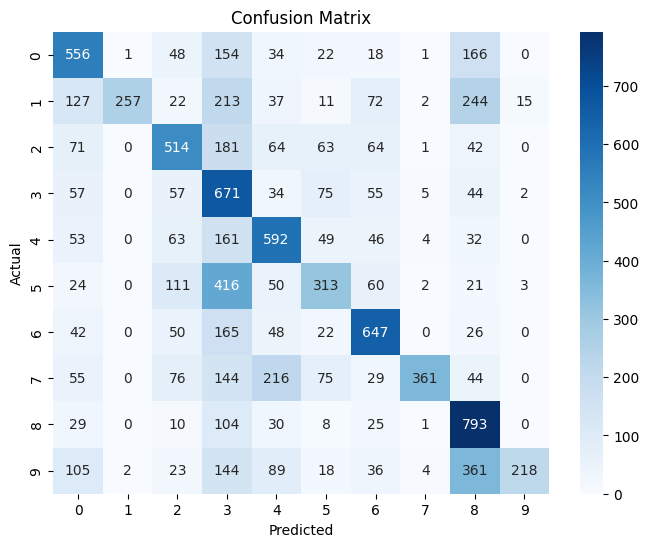

In [35]:
# Evaluate model performance
def evaluate(generator, target_model, test_loader, device):
    generator.eval()
    target_model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            perturbations = torch.clamp(perturbations, -0.3, 0.3)
            perturbed_images = torch.clamp(images + perturbations, 0, 1)

            outputs = target_model(perturbed_images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate attack success
evaluate(trained_generator, target_model, test_loader, device='cuda')


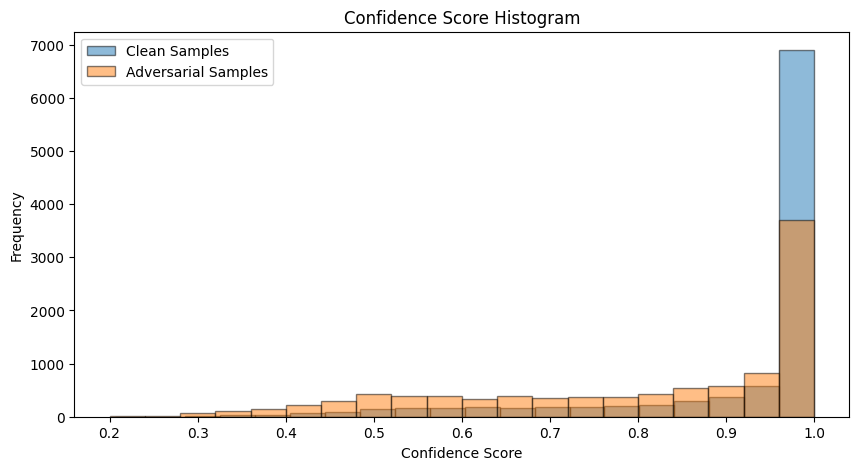

In [37]:
def plot_confidence_histogram(generator, target_model, data_loader, device):
    generator.eval()
    target_model.eval()

    clean_confidences = []
    adv_confidences = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)

            # Clean predictions and confidence scores
            clean_outputs = target_model(images)
            clean_probs = torch.nn.functional.softmax(clean_outputs, dim=1)
            clean_confidences.extend(clean_probs.max(dim=1)[0].cpu().numpy())  # Max confidence score

            # Generate adversarial samples
            perturbations = generator(images)
            perturbations = torch.clamp(perturbations, -0.3, 0.3)
            adv_images = torch.clamp(images + perturbations, 0, 1)

            # Adversarial predictions and confidence scores
            adv_outputs = target_model(adv_images)
            adv_probs = torch.nn.functional.softmax(adv_outputs, dim=1)
            adv_confidences.extend(adv_probs.max(dim=1)[0].cpu().numpy())  # Max confidence score

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(clean_confidences, bins=20, alpha=0.5, label="Clean Samples", edgecolor="black")
    plt.hist(adv_confidences, bins=20, alpha=0.5, label="Adversarial Samples", edgecolor="black")
    plt.xlabel("Confidence Score")
    plt.ylabel("Frequency")
    plt.title("Confidence Score Histogram")
    plt.legend()
    plt.show()

plot_confidence_histogram(trained_generator, target_model, test_loader, device)


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1/50 | D Loss: 1.4379 | G Loss: 167.4120 | Adv Loss: 0.8750 | Perturb Loss: 15.2783


Model accuracy on original test set: 81.13%
Attack success rate: 53.81%


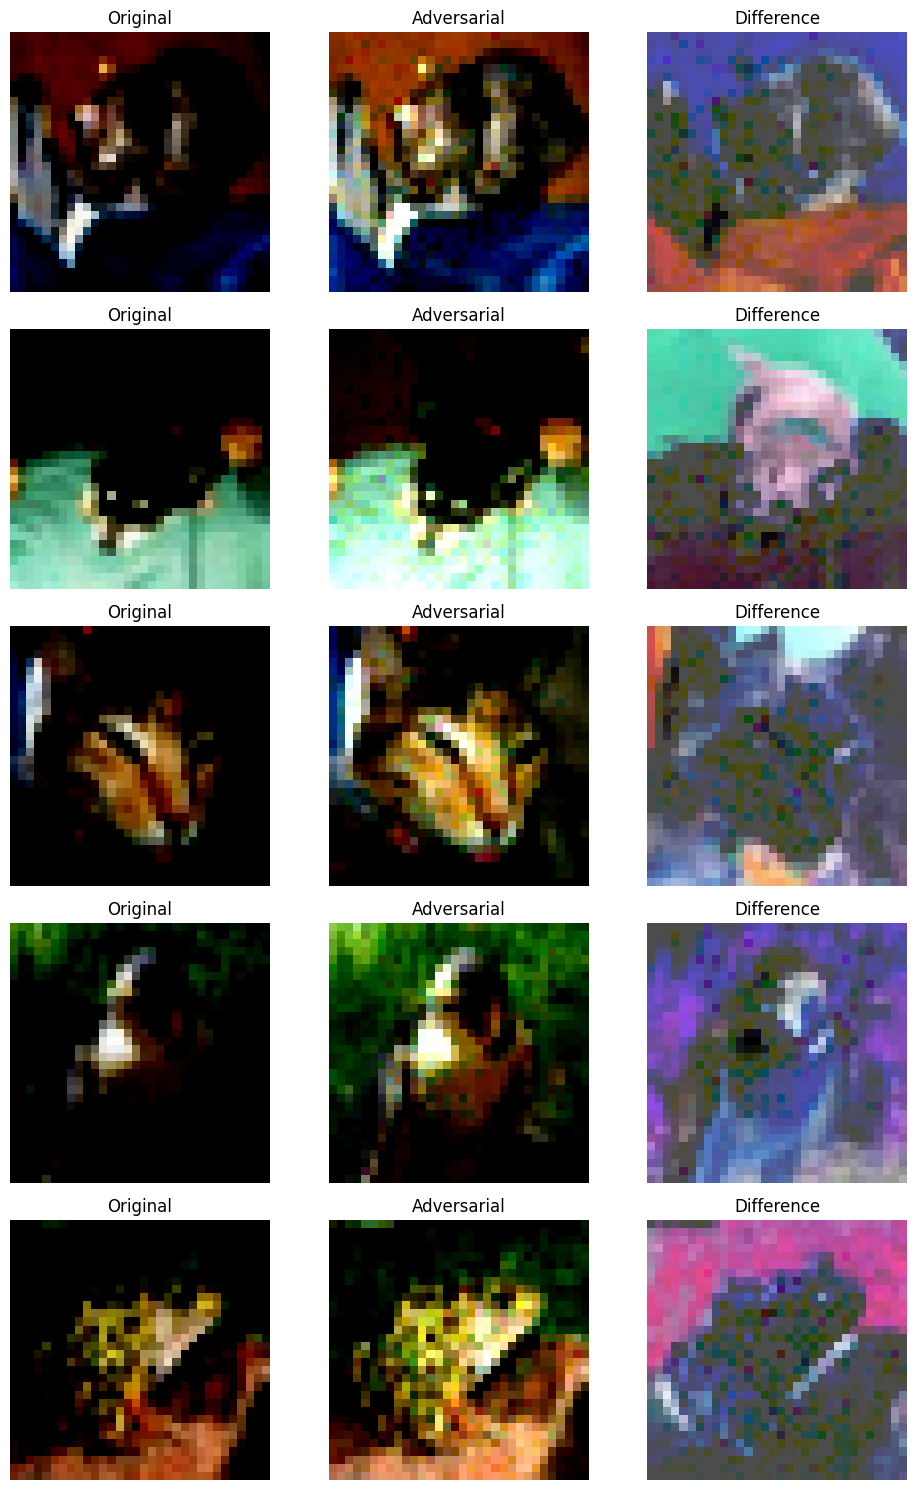

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2/50 | D Loss: 1.6877 | G Loss: 174.9311 | Adv Loss: 0.9167 | Perturb Loss: 15.2788


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3/50 | D Loss: 1.5387 | G Loss: 176.6417 | Adv Loss: 0.8472 | Perturb Loss: 15.2817


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4/50 | D Loss: 0.5456 | G Loss: 179.0425 | Adv Loss: 0.9444 | Perturb Loss: 15.2789


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5/50 | D Loss: 0.7934 | G Loss: 180.3074 | Adv Loss: 0.8889 | Perturb Loss: 15.2778


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6/50 | D Loss: 0.3712 | G Loss: 182.1169 | Adv Loss: 0.7917 | Perturb Loss: 15.2855
Model accuracy on original test set: 81.13%
Attack success rate: 53.82%


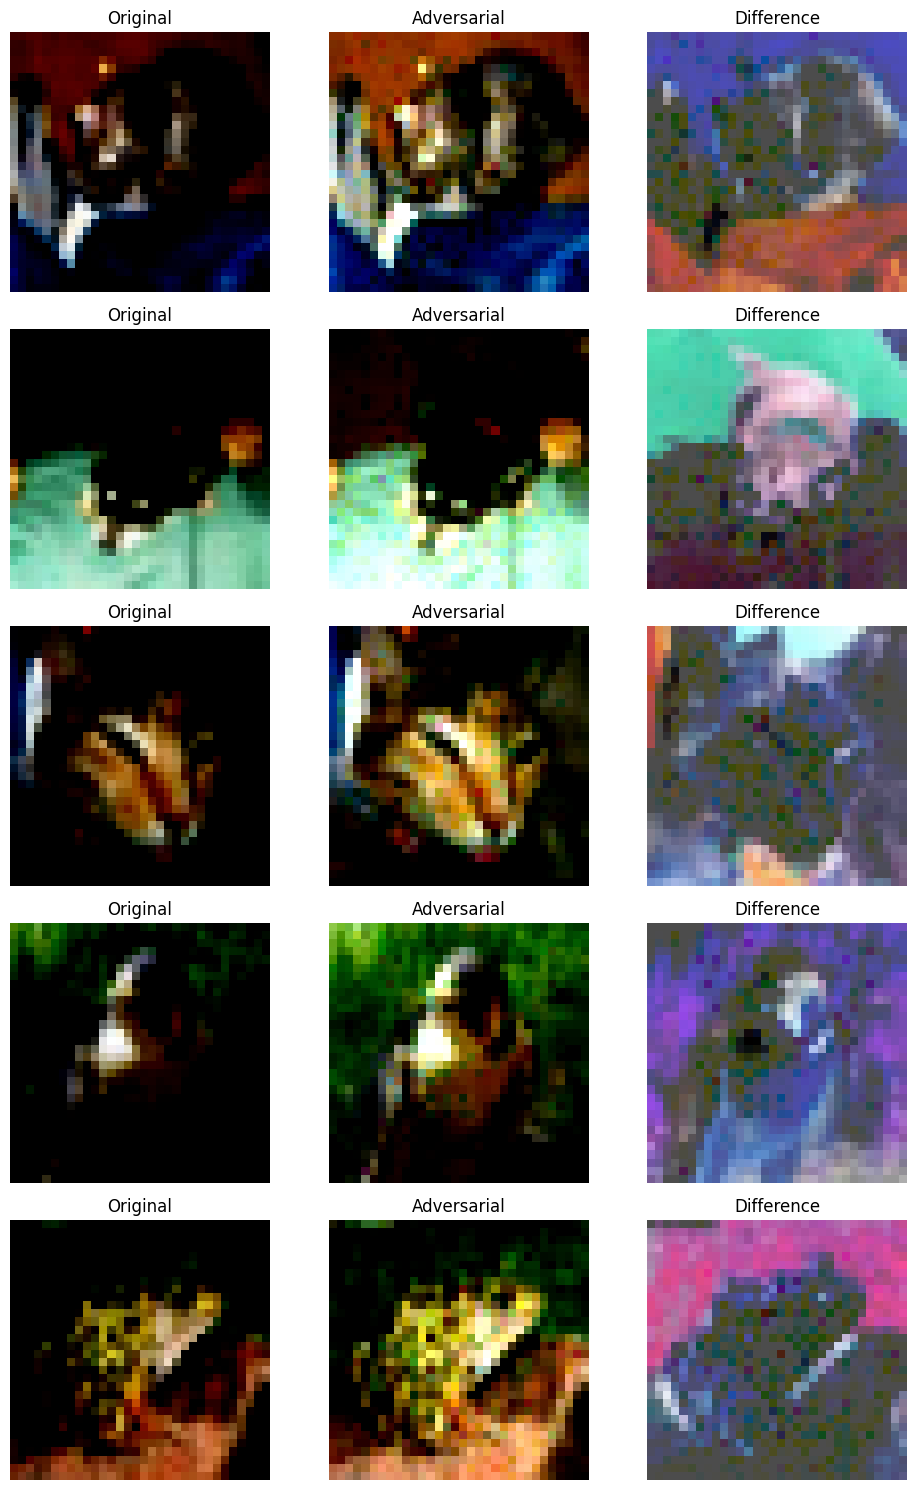

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 7/50 | D Loss: 0.5624 | G Loss: 179.8881 | Adv Loss: 0.9583 | Perturb Loss: 15.2862


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 8/50 | D Loss: 0.5603 | G Loss: 181.0787 | Adv Loss: 0.8472 | Perturb Loss: 15.2798


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 9/50 | D Loss: 0.3392 | G Loss: 182.7019 | Adv Loss: 0.8889 | Perturb Loss: 15.2806


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/50 | D Loss: 0.1798 | G Loss: 180.7291 | Adv Loss: 0.8611 | Perturb Loss: 15.2783


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 11/50 | D Loss: 0.1420 | G Loss: 183.0205 | Adv Loss: 0.8889 | Perturb Loss: 15.2806


Model accuracy on original test set: 81.13%
Attack success rate: 53.83%


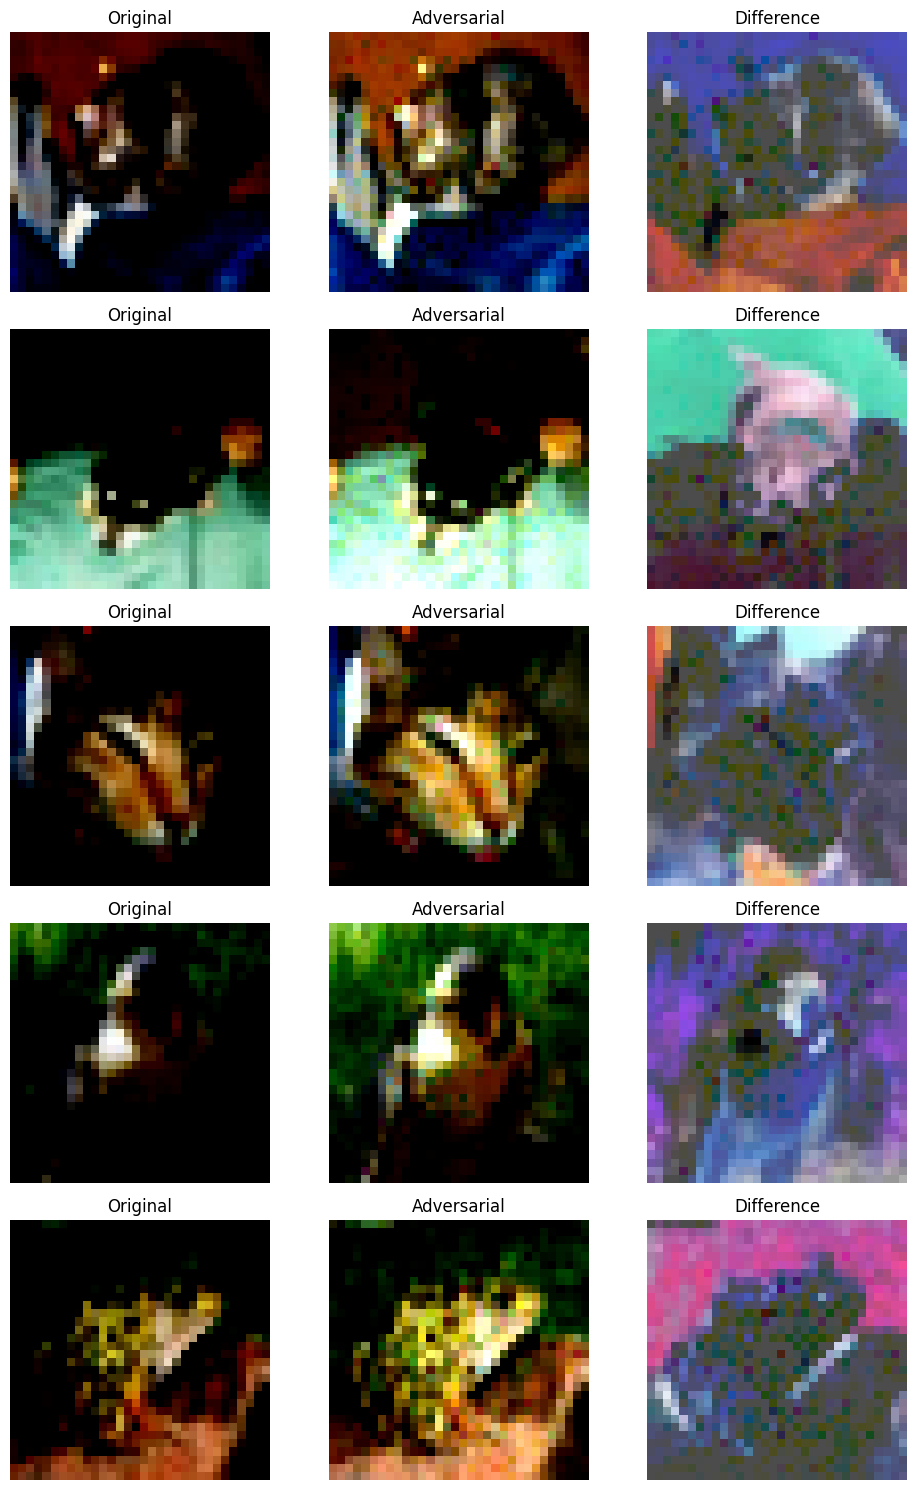

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 12/50 | D Loss: 0.0448 | G Loss: 182.9160 | Adv Loss: 0.8611 | Perturb Loss: 15.2781


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 13/50 | D Loss: 0.3485 | G Loss: 182.8991 | Adv Loss: 0.8611 | Perturb Loss: 15.2777


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 14/50 | D Loss: 0.0190 | G Loss: 183.8588 | Adv Loss: 0.9028 | Perturb Loss: 15.2823


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15/50 | D Loss: 0.1973 | G Loss: 182.8830 | Adv Loss: 0.9028 | Perturb Loss: 15.2775


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 16/50 | D Loss: 0.1684 | G Loss: 182.0282 | Adv Loss: 0.8333 | Perturb Loss: 15.2848


Model accuracy on original test set: 81.13%
Attack success rate: 53.86%


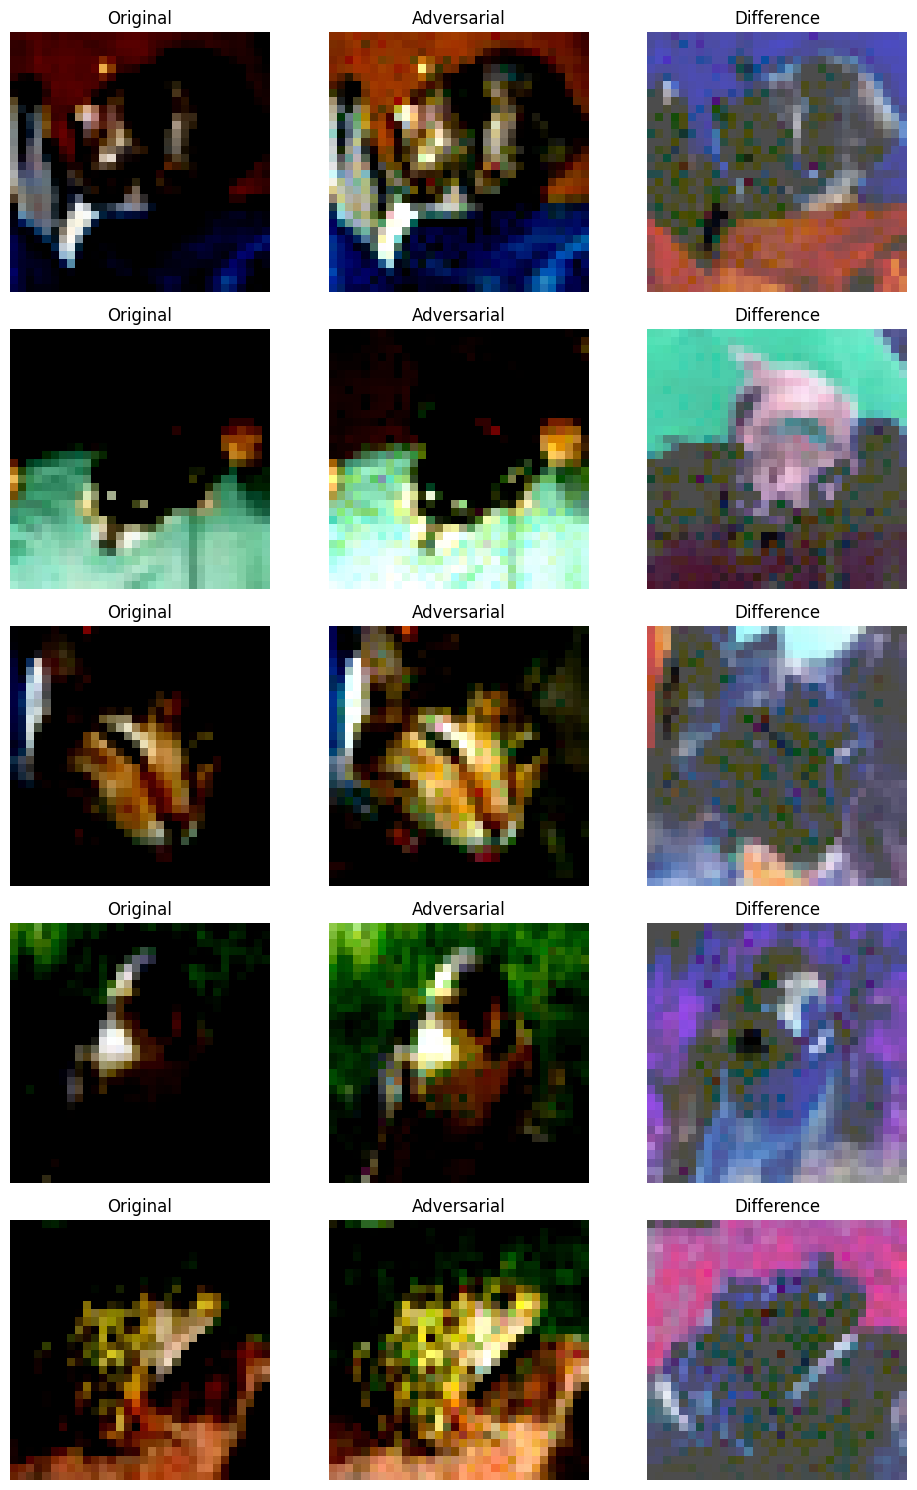

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 17/50 | D Loss: 0.1616 | G Loss: 178.8764 | Adv Loss: 0.8889 | Perturb Loss: 15.2896


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 18/50 | D Loss: 1.0532 | G Loss: 182.9912 | Adv Loss: 0.9167 | Perturb Loss: 15.2852


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 19/50 | D Loss: 0.0253 | G Loss: 183.7772 | Adv Loss: 0.8889 | Perturb Loss: 15.2765


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20/50 | D Loss: 0.1767 | G Loss: 183.2365 | Adv Loss: 0.8611 | Perturb Loss: 15.2830


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 21/50 | D Loss: 0.2229 | G Loss: 183.7917 | Adv Loss: 0.8750 | Perturb Loss: 15.2848


Model accuracy on original test set: 81.13%
Attack success rate: 53.80%


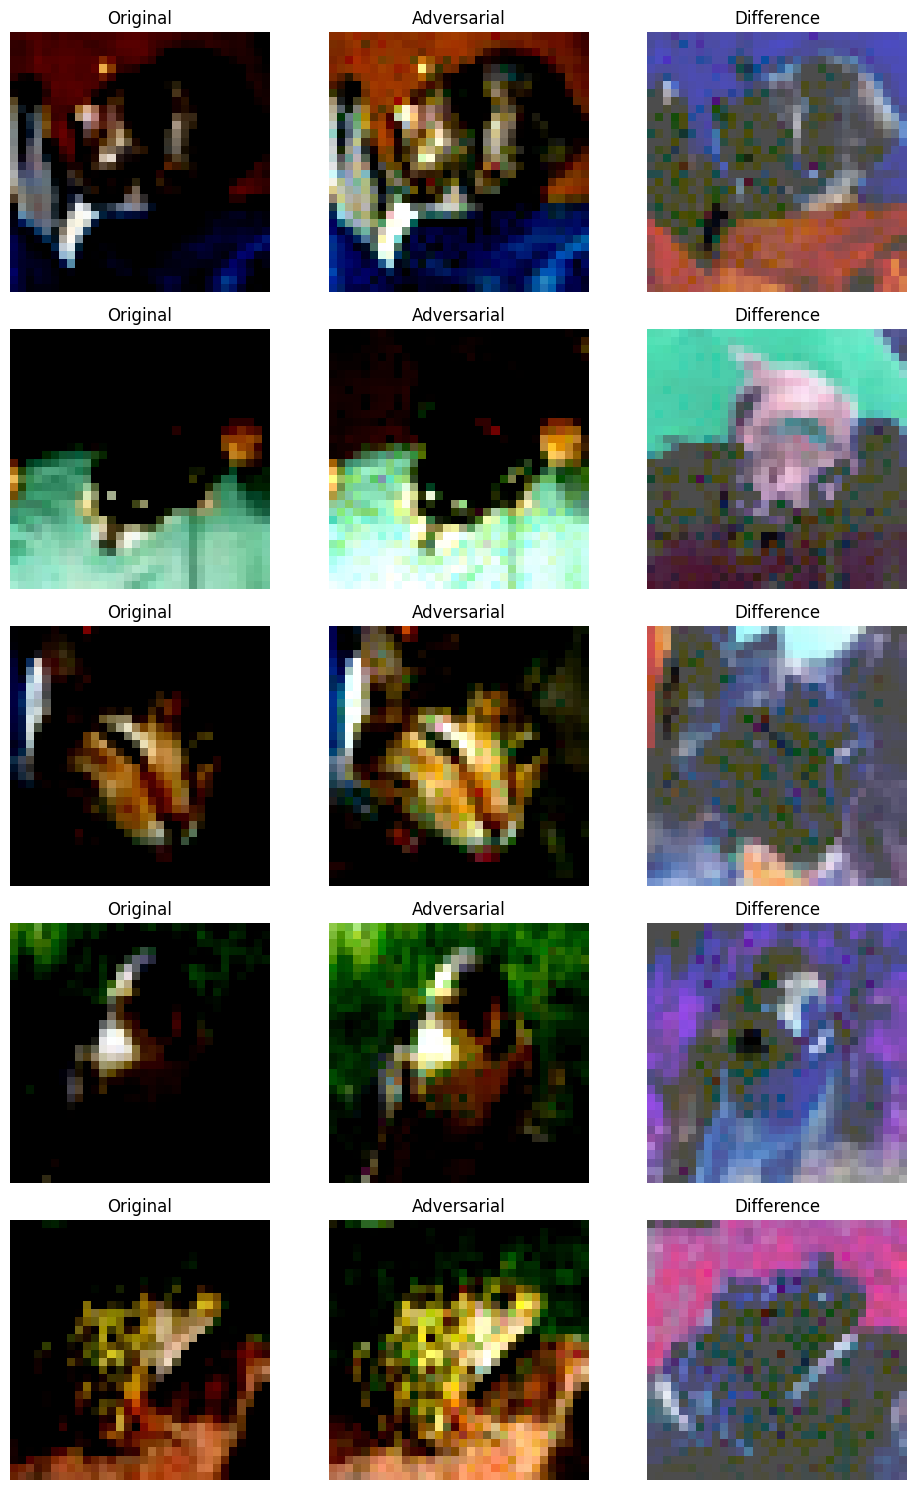

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 22/50 | D Loss: 0.0152 | G Loss: 183.9629 | Adv Loss: 0.9167 | Perturb Loss: 15.2830


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 23/50 | D Loss: 0.0077 | G Loss: 183.9594 | Adv Loss: 0.8889 | Perturb Loss: 15.2792


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 24/50 | D Loss: 0.0303 | G Loss: 183.9290 | Adv Loss: 0.8889 | Perturb Loss: 15.2923


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25/50 | D Loss: 0.0067 | G Loss: 183.6329 | Adv Loss: 0.9306 | Perturb Loss: 15.2790


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 26/50 | D Loss: 1.0392 | G Loss: 181.0444 | Adv Loss: 0.8611 | Perturb Loss: 15.2788


Model accuracy on original test set: 81.13%
Attack success rate: 53.86%


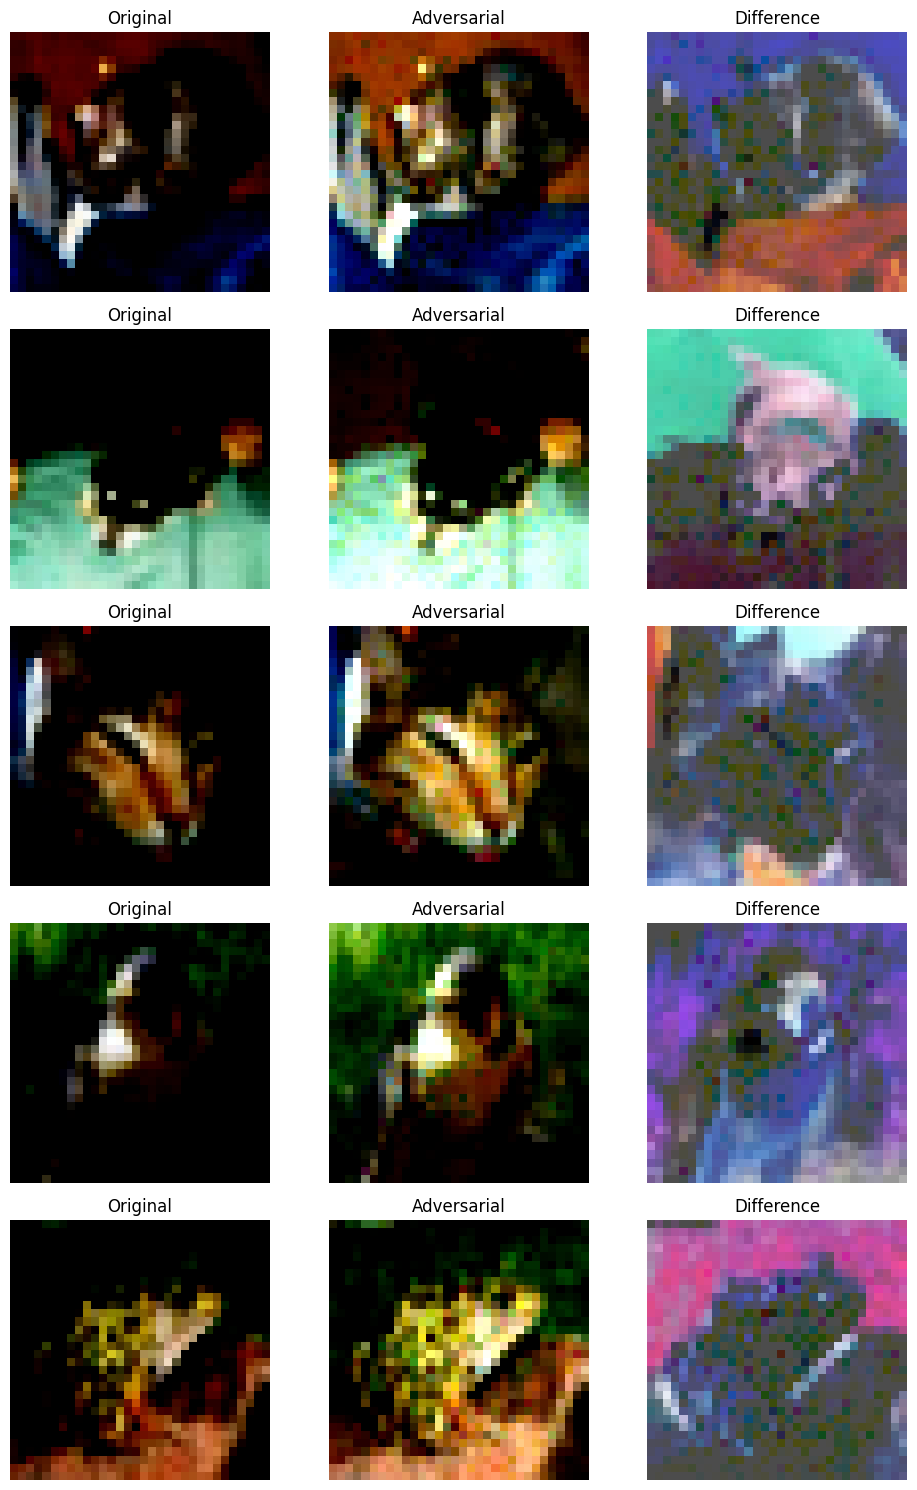

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 27/50 | D Loss: 0.0091 | G Loss: 183.8310 | Adv Loss: 0.8611 | Perturb Loss: 15.2879


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 28/50 | D Loss: 0.0588 | G Loss: 183.5485 | Adv Loss: 0.8750 | Perturb Loss: 15.2842


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 29/50 | D Loss: 0.0114 | G Loss: 183.8465 | Adv Loss: 0.9028 | Perturb Loss: 15.2895


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 30/50 | D Loss: 0.2283 | G Loss: 183.0321 | Adv Loss: 0.9028 | Perturb Loss: 15.2810


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 31/50 | D Loss: 0.0077 | G Loss: 183.5349 | Adv Loss: 0.9167 | Perturb Loss: 15.2764


Model accuracy on original test set: 81.13%
Attack success rate: 53.84%


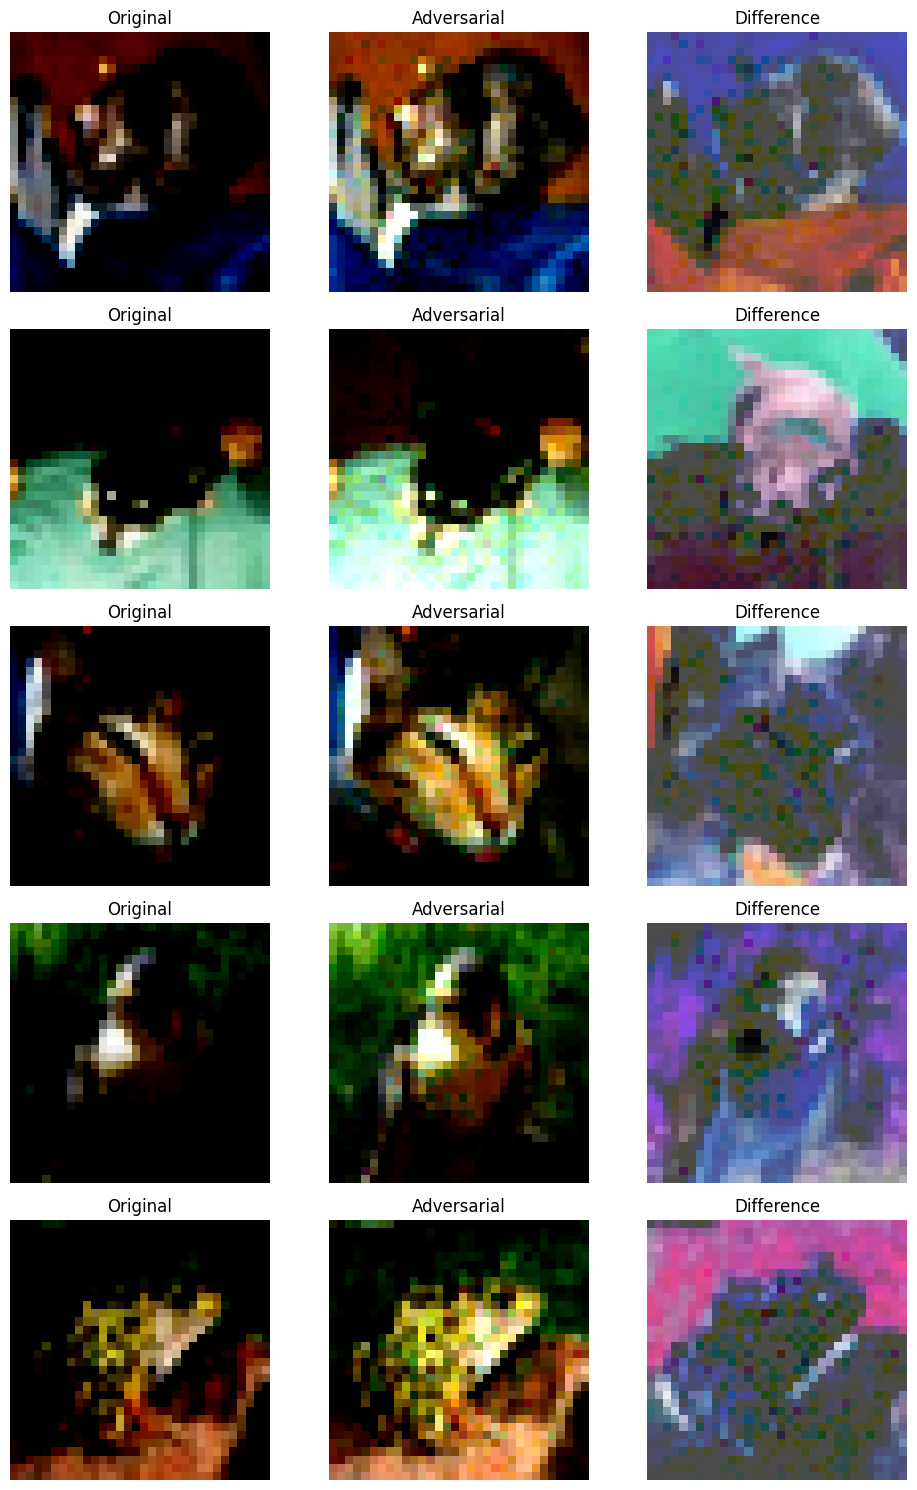

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 32/50 | D Loss: 0.0125 | G Loss: 183.4135 | Adv Loss: 0.8889 | Perturb Loss: 15.2846


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 33/50 | D Loss: 0.9135 | G Loss: 183.8554 | Adv Loss: 0.9583 | Perturb Loss: 15.2763


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 34/50 | D Loss: 0.1328 | G Loss: 182.4987 | Adv Loss: 0.9306 | Perturb Loss: 15.2859


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 35/50 | D Loss: 0.0017 | G Loss: 184.0495 | Adv Loss: 0.9306 | Perturb Loss: 15.2815


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 36/50 | D Loss: 0.0351 | G Loss: 183.4277 | Adv Loss: 0.8611 | Perturb Loss: 15.2746


Model accuracy on original test set: 81.13%
Attack success rate: 53.83%


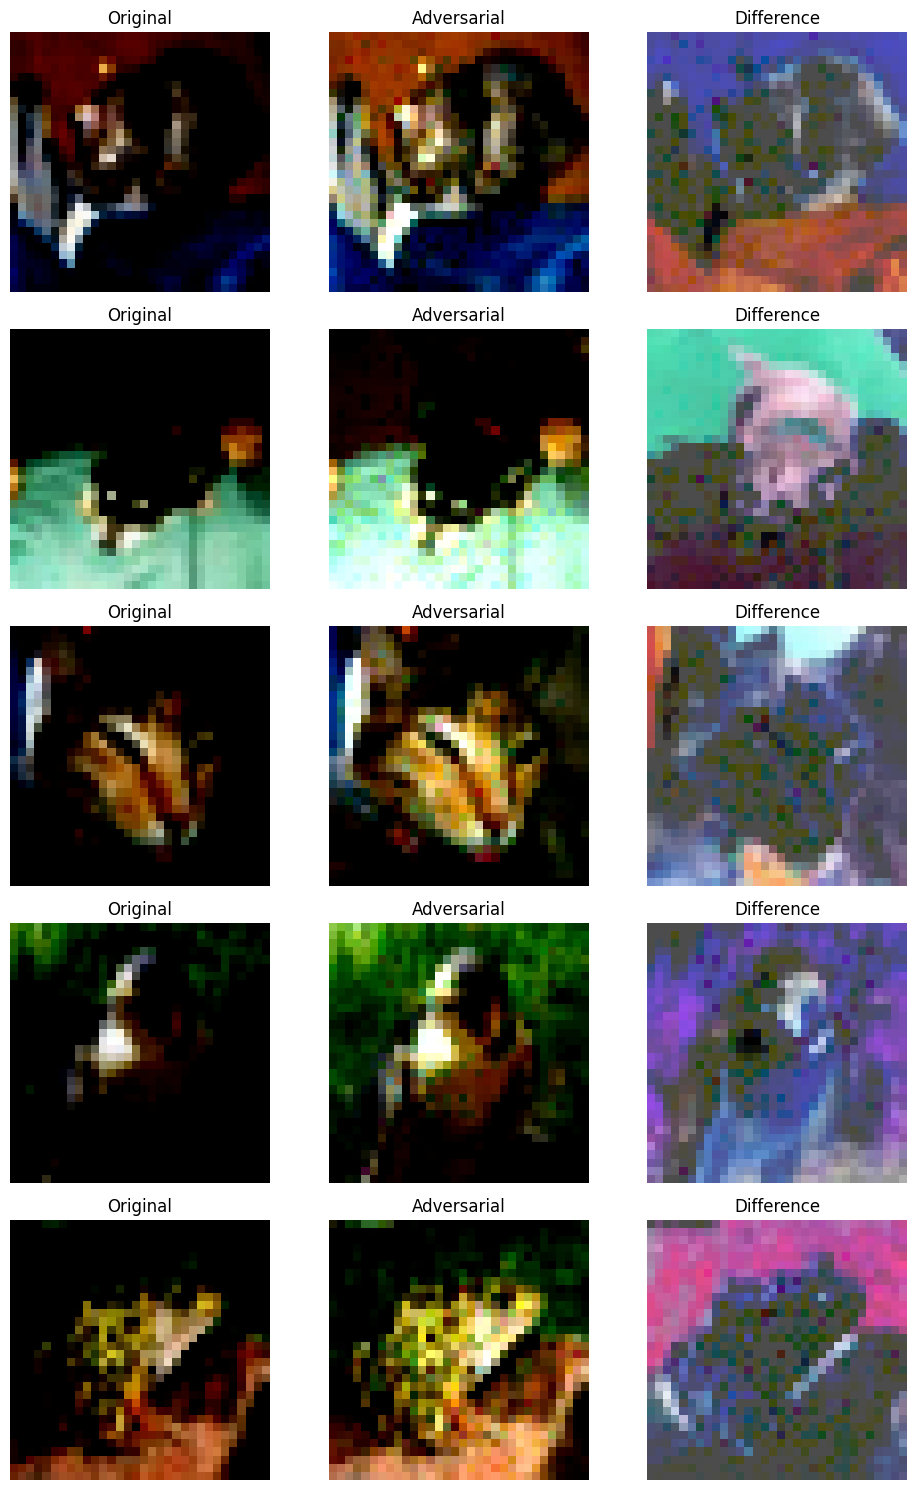

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 37/50 | D Loss: 0.6760 | G Loss: 183.9725 | Adv Loss: 0.8472 | Perturb Loss: 15.2760


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 38/50 | D Loss: 0.7427 | G Loss: 182.7570 | Adv Loss: 0.9028 | Perturb Loss: 15.2820


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 39/50 | D Loss: 0.0075 | G Loss: 184.0485 | Adv Loss: 0.9306 | Perturb Loss: 15.2841


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 40/50 | D Loss: 0.0065 | G Loss: 184.0460 | Adv Loss: 0.9306 | Perturb Loss: 15.2799


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 41/50 | D Loss: 0.0533 | G Loss: 183.9403 | Adv Loss: 0.9306 | Perturb Loss: 15.2865
Model accuracy on original test set: 81.13%
Attack success rate: 53.76%


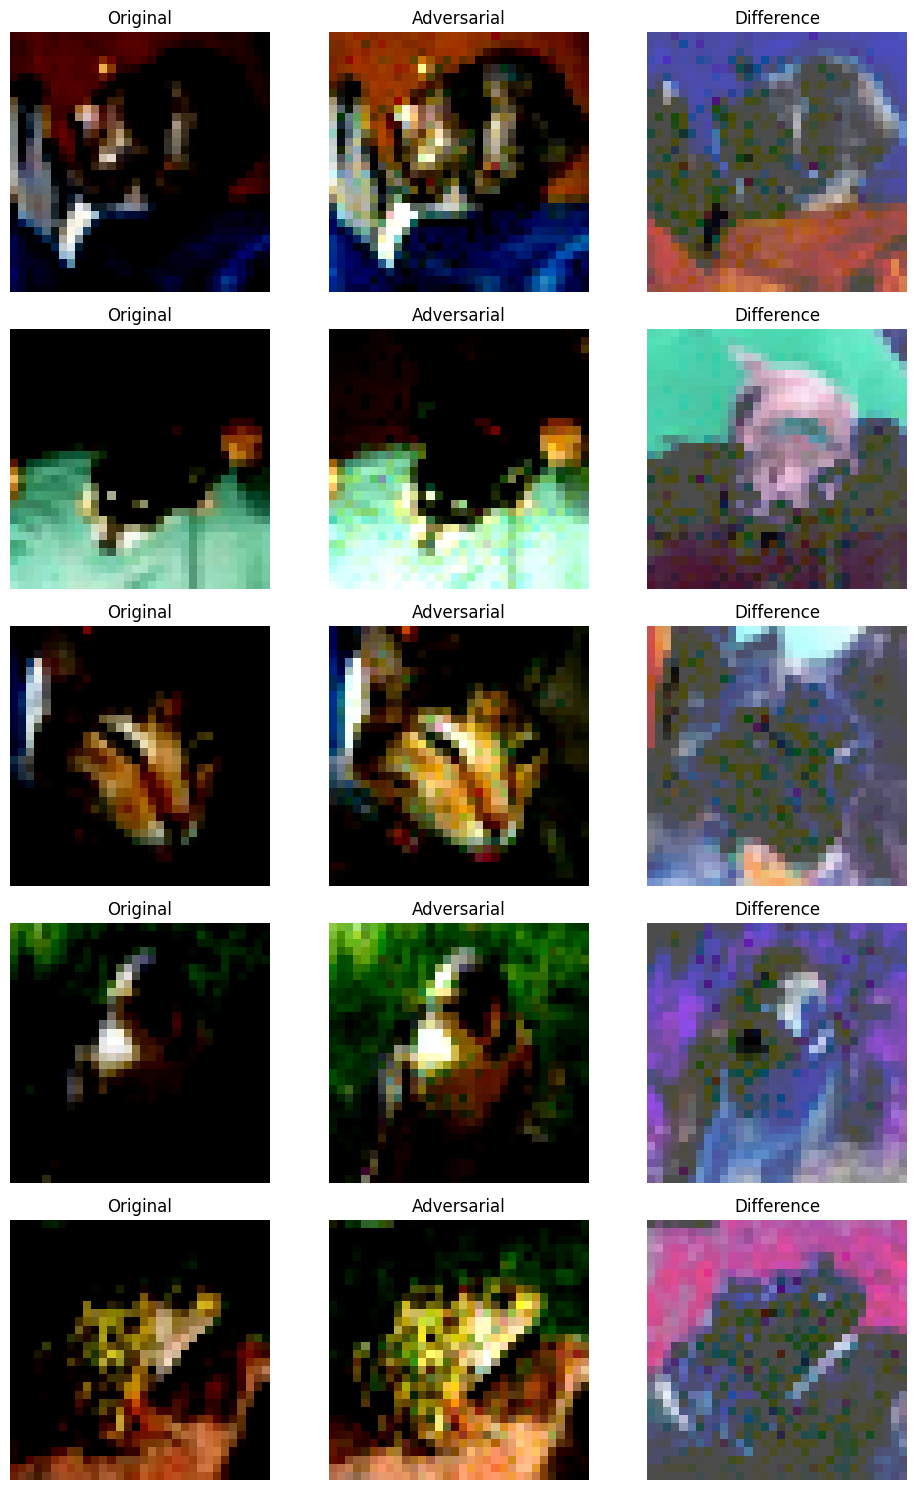

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 42/50 | D Loss: 0.0014 | G Loss: 183.9442 | Adv Loss: 0.9306 | Perturb Loss: 15.2808


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 43/50 | D Loss: 0.0015 | G Loss: 183.9922 | Adv Loss: 0.8750 | Perturb Loss: 15.2785


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 44/50 | D Loss: 0.0051 | G Loss: 183.8546 | Adv Loss: 0.9167 | Perturb Loss: 15.2766


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 45/50 | D Loss: 0.0010 | G Loss: 184.0183 | Adv Loss: 0.8472 | Perturb Loss: 15.2829


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 46/50 | D Loss: 0.0511 | G Loss: 183.9816 | Adv Loss: 0.8889 | Perturb Loss: 15.2817


Model accuracy on original test set: 81.13%
Attack success rate: 53.83%


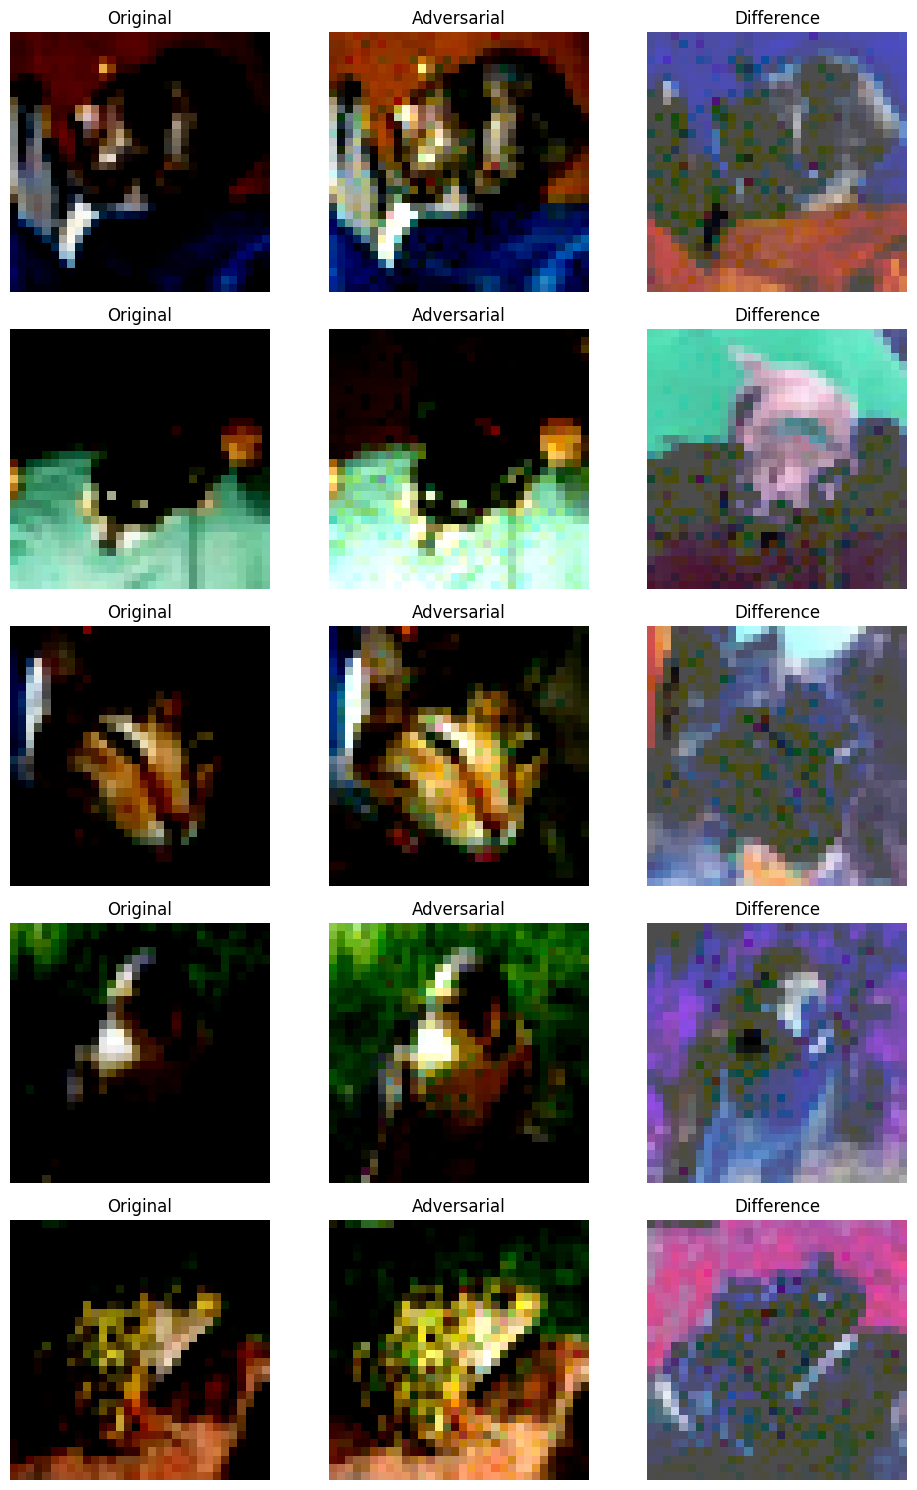

  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 47/50 | D Loss: 0.1802 | G Loss: 183.4622 | Adv Loss: 0.8611 | Perturb Loss: 15.2833


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 48/50 | D Loss: 0.2521 | G Loss: 183.9206 | Adv Loss: 0.8333 | Perturb Loss: 15.2815


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 49/50 | D Loss: 0.0088 | G Loss: 184.0137 | Adv Loss: 0.8889 | Perturb Loss: 15.2812


  0%|          | 0/352 [00:00<?, ?it/s]

Epoch 50/50 | D Loss: 0.0004 | G Loss: 183.9921 | Adv Loss: 0.8889 | Perturb Loss: 15.2925


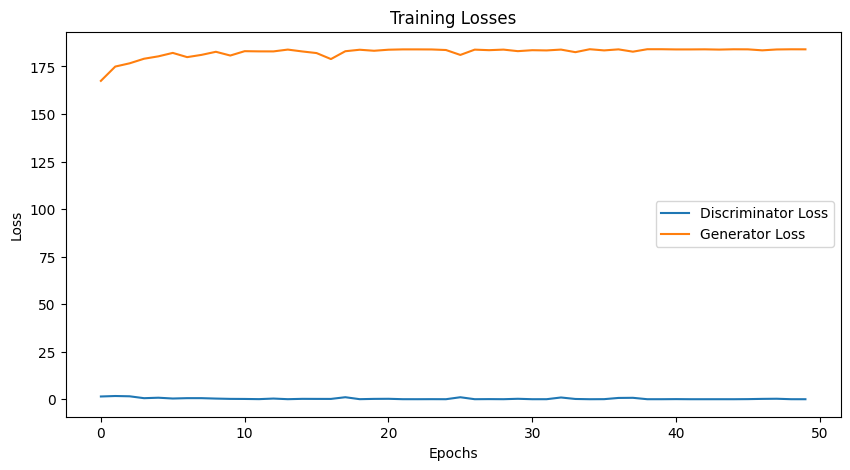

In [45]:
# Initialize models and train
generator = Generator()
discriminator = Discriminator()
targeted_trained_generator, targeted_trained_discriminator = train_advgan(generator, discriminator, target_model, train_loader, val_loader, target=2)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model accuracy on original test set: 81.13%
Attack success rate: 53.83%


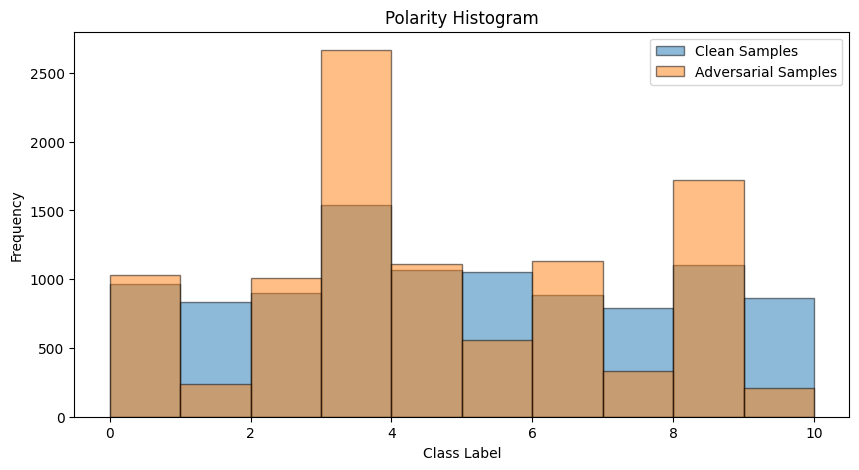

In [46]:
compute_attack_success(targeted_trained_generator, target_model, test_loader, threshold=0.3, device='cuda')

# Plot polarity histogram
plot_polarity_histogram(targeted_trained_generator, target_model, test_loader, device)


In [47]:
adversarial_images, original_images, differences = compute_attack_success_per_class(targeted_trained_generator, target_model, test_loader, threshold=0.3, device='cuda', num_classes=10)


Model accuracy on original test set: 81.13%
Overall attack success rate: 53.83%
Class 0:
  Accuracy: 84.10%
  Attack Success Rate: 50.40%
Class 1:
  Accuracy: 82.00%
  Attack Success Rate: 76.10%
Class 2:
  Accuracy: 74.20%
  Attack Success Rate: 50.50%
Class 3:
  Accuracy: 82.50%
  Attack Success Rate: 29.70%
Class 4:
  Accuracy: 83.50%
  Attack Success Rate: 46.00%
Class 5:
  Accuracy: 73.00%
  Attack Success Rate: 74.10%
Class 6:
  Accuracy: 80.40%
  Attack Success Rate: 35.60%
Class 7:
  Accuracy: 76.70%
  Attack Success Rate: 68.50%
Class 8:
  Accuracy: 92.40%
  Attack Success Rate: 26.40%
Class 9:
  Accuracy: 82.50%
  Attack Success Rate: 81.00%


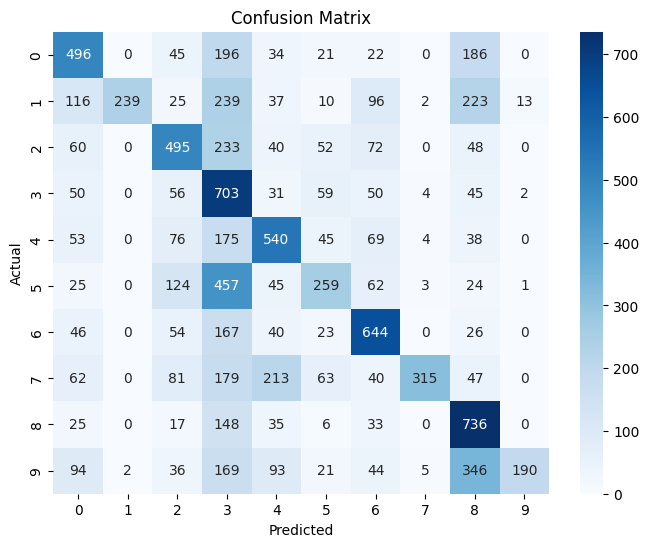

In [48]:
# Evaluate model performance
def evaluate(generator, target_model, test_loader, device):
    generator.eval()
    target_model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            perturbations = torch.clamp(perturbations, -0.3, 0.3)
            perturbed_images = torch.clamp(images + perturbations, 0, 1)

            outputs = target_model(perturbed_images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate attack success
evaluate(targeted_trained_generator, target_model, test_loader, device='cuda')


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


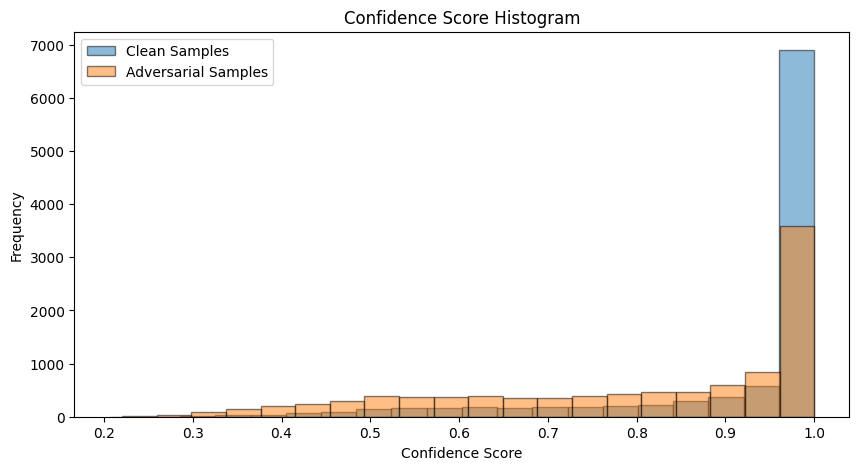

In [49]:
plot_confidence_histogram(targeted_trained_generator, target_model, test_loader, device)
